In [47]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas.api.types import CategoricalDtype
from typing import List, Dict, Optional, Tuple, Any
from joblib import Parallel, delayed
from scipy.optimize import minimize, Bounds, LinearConstraint
from numba import njit

from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14  # Minimum font size

## Functions

In [150]:
def calculate_additional_capacity(
    data: pd.DataFrame,
    source_cols: List[str],
    capacity_map: dict[str, float],
    reduction_targets: List[float] = [0.05, 0.10, 0.25, 0.50],
    storage_gwh: float = 0.0,
    resid_keyword: str = "no growth",
    expand_techs: Optional[List[str]] = None
) -> pd.DataFrame:
    """
    Calculate additional MW of capacity needed per tech
    to reduce residual load by given fractions.

    Works in two modes:
      1) Multi-scenario (source_cols like 'RCP2_6_Wind', …)
      2) Single-scenario (any other source_cols)

    Parameters
    ----------
    data : pd.DataFrame
      Contains generation (kWh) & residual load (GWh).
    source_cols : list of str
      Either RCP… columns or plain tech columns (e.g. 'Wind EDP').
    capacity_map : dict
      Installed capacity in MW, keys = tech names lower-case.
    reduction_targets : list of float
      Fractions of residual load to shave off.
    storage_gwh : float
      GWh of storage to subtract first.
    resid_keyword : str
      Substring to pick residual load column (optional).
    expand_techs : list of str, optional
      Which techs to expand (subset of capacity_map keys).

    Returns
    -------
    pd.DataFrame
      Columns: scenario, technology, reduction, additional_capacity_mw
    """
    rows = []

    # --- detect mode ---
    is_multi = all(re.match(r"RCP\d+_[0-9]_\w+", c) for c in source_cols)

    if is_multi:
        # same as before: group by RCP scenario
        tech_by_scenario: dict[str, dict[str,str]] = {}
        for col in source_cols:
            m = re.match(r"(RCP\d+_[0-9])_(\w+)", col)
            scenario, tech = m.groups()
            tech_by_scenario.setdefault(scenario, {})[tech.lower()] = col

    else:
        # single scenario: lump all source_cols under one empty-string scenario
        tech_by_scenario = {"": {
            # normalize tech name from column, e.g. 'Wind EDP' → 'wind'
            re.sub(r"\s+EDP$", "", col, flags=re.IGNORECASE).lower(): col
            for col in source_cols
        }}

    # --- find residual column(s) and compute ---
    for scenario, tech_cols in tech_by_scenario.items():
        # find residual column
        if is_multi:
            scen_num = scenario.replace("RCP","").replace("_",".")
            resid_pattern = rf"Residual Load.*RCP\s*{re.escape(scen_num)}.*{re.escape(resid_keyword)}"
        else:
            resid_pattern = rf"Residual Load.*{re.escape(resid_keyword)}"

        regex = re.compile(resid_pattern, re.IGNORECASE)
        matches = [c for c in data.columns if regex.search(c)]
        if not matches:
            raise KeyError(f"No residual-load column matching /{resid_pattern}/")
        resid_col = matches[0]

        total_resid = data[resid_col].sum()
        effective_resid = max(total_resid - storage_gwh, 0.0)

        # filter techs
        filtered = {
            tech: col_name
            for tech, col_name in tech_cols.items()
            if expand_techs is None or tech in expand_techs
        }
        if not filtered:
            continue

        # compute GWh per MW for each tech
        gen_per_mw = {}
        for tech, gen_col in filtered.items():
            total_gen_gwh = data[gen_col].sum() / 1e6
            cap = capacity_map.get(tech)
            if cap is None or total_gen_gwh <= 0:
                raise ValueError(f"Invalid data for tech '{tech}'")
            gen_per_mw[tech] = total_gen_gwh / cap

        # if multi-tech, allocate by cap share
        share_denom = sum(capacity_map[t] for t in filtered)

        for frac in reduction_targets:
            needed = frac * effective_resid
            for tech in filtered:
                alloc = needed if len(filtered)==1 else needed * (capacity_map[tech]/share_denom)
                add_mw = alloc / gen_per_mw[tech]
                rows.append({
                    "scenario": scenario.replace("_","."),  # "" → ""
                    "technology": tech,
                    "reduction": f"{int(frac*100)}%",
                    "additional_capacity_mw": add_mw
                })

    return pd.DataFrame(rows)


def compute_vre_variability(df, datetime_col, source_cols, windows=None, start_year=2035, end_year=2045):
    """
    Computes variability of energy sources (in kWh) over different time resolutions,
    expressing the coefficient of variation (CV) as a function of installed capacity.

    Parameters:
    - df: pandas DataFrame with time series data in kWh
    - datetime_col: name of the datetime column (e.g., 'LocalTime')
    - source_cols: list of energy source columns
    - windows: dict of label:resample_freq (optional)
    - start_year: int, start of the year range (inclusive)
    - end_year: int, end of the year range (exclusive)

    Returns:
    - DataFrame with combined 'STD (CV)' format (STD in GWh, CV relative to capacity)
    """
    # Capacity reference in MW
    capacity_map = {
        'hydro': 5220,
        'photovoltaics': 539,
        'wind': 1198
    }

    if windows is None:
        windows = {
            '15min': '15min',
            '1h': '1h',
            '4h': '4h',
            '8h': '8h',
            '24h': '1D',
            '48h': '2D',
            '7d': '7D',
            '30d': '30D',
            '1y': '365D',
        }

    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.set_index(datetime_col)

    # Filter for the target date range
    df = df[(df.index.year >= start_year) & (df.index.year < end_year)]

    results = {}

    for label, freq in windows.items():
        results[label] = {}
        for source in source_cols:
            resampled = df[source].resample(freq).sum()
            resampled_gwh = resampled / 1_000_000  # convert to GWh

            std = resampled_gwh.std()

            # Extract the energy type from the column name
            source_lower = source.lower()
            matched_capacity = None
            for key in capacity_map:
                if key in source_lower:
                    matched_capacity = capacity_map[key]
                    break

            if matched_capacity is None:
                raise ValueError(f"Could not determine installed capacity for column '{source}'")

            # Compute average period duration
            if len(resampled.index) > 1:
                period_hours = (resampled.index[1] - resampled.index[0]).total_seconds() / 3600
            else:
                period_hours = pd.Timedelta(freq).total_seconds() / 3600

            expected_max_gwh = (matched_capacity * period_hours) / 1000

            cv = std / expected_max_gwh if expected_max_gwh != 0 else float('nan')

            results[label][source] = f"{std:.2f} ({cv:.2f})"

    return pd.DataFrame(results).T


def compute_residual_load_metrics(forecast: pd.DataFrame) -> pd.DataFrame:
    """
    Computes residual load metrics for each combination of RCP scenario, hydro exclusion, growth factor, and add flag.
    Returns a DataFrame with:
      - scenario: RCP scenario (2.6, 4.5, 8.5)
      - hydro: 'with hydro' or 'ex. hydro'
      - growth: 'no growth' or 'w growth'
      - add: 'without add' or 'add'
      - % RL > 0: percentage of intervals with residual load > 0
      - Peak Daily RL (GWh): maximum daily total residual load
      - Peak 15min RL (GWh): maximum 15‑min residual load
      - Peak 4h RL (GWh): maximum rolling 4‑hour sum of residual load
      - Average Yearly RL (GWh): average of annual total residual load across years
    """
    df = forecast.copy()
    df['date'] = df['LocalTime'].dt.date
    df['year'] = df['LocalTime'].dt.year

    scenarios = ['2.6', '4.5', '8.5']
    growth_map = {'no growth': 'no growth', 'w growth': 'w growth'}
    add_map = {'without add': '', 'add': ' add'}
    hydro_map = {'with hydro': '', 'ex. hydro': ' ex. Hydro'}

    records = []
    for scenario in scenarios:
        for hydro_label, hydro_suffix in hydro_map.items():
            for growth_label, growth in growth_map.items():
                for add_label, add_suffix in add_map.items():
                    col = f"Residual Load (GWh) EDP RCP {scenario}{hydro_suffix} {growth}{add_suffix}"
                    if col not in df.columns:
                        continue
                    series = df[col]

                    pct_positive = (series > 0).sum() / len(series) * 100
                    peak_15min = series.max()
                    peak_daily = df.groupby('date')[col].sum().max()
                    peak_4h = series.rolling(window=16, min_periods=1).sum().max()
                    yearly_totals = df.groupby('year')[col].sum()
                    avg_yearly = yearly_totals.mean()

                    records.append({
                        'scenario': scenario,
                        'hydro': hydro_label,
                        'growth': growth_label,
                        'add': add_label,
                        '% RL > 0': pct_positive,
                        'Peak Daily RL (GWh)': peak_daily,
                        'Peak 15min RL (GWh)': peak_15min,
                        'Peak 4h RL (GWh)': peak_4h,
                        'Average Yearly RL (GWh)': avg_yearly
                    })

    return pd.DataFrame.from_records(records)


def optimize_investment_mix_multi_year_old(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = 2025,
    end_year: int = 2050,
    annual_investment_eur: float = 1e9,
    growth_rate: float = 0.0,
    exchange_rate: float = 1 / 1.10,
    delta_mw: float = 1.0,
    delta_batt_gwh: float = 0.1,
    method: str = 'greedy'
) -> Tuple[pd.DataFrame, Dict[str, Dict[int, Dict[str, float]]]]:
    """
    Multi-year VRE + storage mix under annual budgets;
    dynamic residual recalculation each year.
    method: 'greedy' for hill-climb, 'slsqp' for SLSQP optimizer.
    """
    # Years and cost interpolation
    years = np.arange(start_year, end_year + 1)
    raw = pd.DataFrame(cost_schedule_usd).T.sort_index()
    all_years = np.union1d(raw.index.values, years)
    filled = raw.reindex(all_years).interpolate().ffill().bfill()
    cost_df = filled.loc[years]

    # EUR per unit costs: EUR/MW for VRE, EUR/GWh for storage
    pv_cost_arr   = cost_df['photovoltaics'] * exchange_rate * 1e3
    wind_cost_arr = cost_df['wind']           * exchange_rate * 1e3
    batt_cost_arr = cost_df['battery']        * exchange_rate * 1e6

    # Scenarios to consider; known codes
    scenario_codes = ['2_6', '4_5', '8_5']
    scenarios = []
    base_profiles = {}
    per_unit = {}

    # Precompute base generation and per-unit factors
    for code in scenario_codes:
        prefix = f'RCP{code}_'
        # Base hourly arrays (GWh units)
        hydro = data[prefix + 'Hydro'].fillna(0).values * 1e-3
        pv0   = data[prefix + 'Photovoltaics'].fillna(0).values * 1e-3
        wind0 = data[prefix + 'Wind'].fillna(0).values * 1e-3
        # Generation per MW (normalized)
        per_unit[prefix] = {
            'photovoltaics': pv0 / capacity_map['photovoltaics'],
            'wind': wind0 / capacity_map['wind']
        }
        # Median kWh arrays
        med_kwh = data['median (kWh)'].fillna(0).values
        no_grow = data['kWh - no_growth'].fillna(0).values
        for growth in ['no_growth', 'w_growth']:
            scen = f'RCP{code} {growth}'
            scenarios.append(scen)
            # store base time series, differentiate by growth flag
            base_profiles[scen] = {
                'hydro': hydro,
                'pv0': pv0,
                'wind0': wind0,
                'median': med_kwh,
                'no_growth': no_grow
            }

    # Storage dispatch helper (profile in GWh, cap in MWh)
    def simulate_storage(profile: np.ndarray, cap_mwh: float) -> np.ndarray:
        soc = 0.0
        out = np.zeros_like(profile)
        for i, net in enumerate(profile):
            if net < 0:
                ch = min(-net, cap_mwh - soc)
                soc += ch
                out[i] = net + ch
            else:
                ds = min(soc, net)
                soc -= ds
                out[i] = net - ds
        return out

    def year_deficit(year_idx: int,
                     scen: str,
                     cum_adds: Tuple[float, float, float]) -> float:
        # dynamic residual: base load minus base gen minus added gen
        base = base_profiles[scen]
        # choose growth or no_growth scaling
        if scen.endswith('w_growth'):
            load = base['median'] * 0.378
        else:
            load = base['no_growth'] * 0.378
        # subtract base hydro and gen
        resid = load - base['hydro'] - base['pv0'] - base['wind0']
        # subtract added VRE
        pv_c, wd_c, batt_c = cum_adds
        resid -= per_unit[f"RCP{scen.split()[0][-3:]}_"]['photovoltaics'] * pv_c
        resid -= per_unit[f"RCP{scen.split()[0][-3:]}_"]['wind'] * wd_c
        # storage
        if batt_c > 0:
            resid = simulate_storage(resid, batt_c * 1e3)
        # positive deficits
        return float(np.clip(resid, 0, None).sum())

    # cumulative deficit for objective
    def total_def(x: np.ndarray) -> float:
        adds = x.reshape((len(years), 3))
        cum = adds.cumsum(axis=0)
        tot = 0.0
        for i in range(len(years)):
            for scen in scenarios:
                tot += year_deficit(i, scen, tuple(cum[i]))
        return tot

    # budgets
    budgets = annual_investment_eur * ((1 + growth_rate) ** (years - start_year))

    # optimization
    if method == 'greedy':
        adds_mat = np.zeros((len(years), 3))
        curr_def = total_def(adds_mat.flatten())
        while True:
            best_rate = 0.0
            best_move = None
            for i in range(len(years)):
                for t, step in enumerate([delta_mw, delta_mw, delta_batt_gwh]):
                    cost = [pv_cost_arr, wind_cost_arr, batt_cost_arr][t].iloc[i] * step
                    if budgets[i] < cost:
                        continue
                    trial = adds_mat.copy()
                    trial[i, t] += step
                    new_def = total_def(trial.flatten())
                    rate = (curr_def - new_def) / cost if cost>0 else 0.0
                    if rate > best_rate:
                        best_rate = rate
                        best_move = (i, t, step, cost)
            if not best_move or best_rate <= 0:
                break
            i_b, t_b, step_b, cost_b = best_move
            adds_mat[i_b, t_b] += step_b
            budgets[i_b] -= cost_b
            curr_def = total_def(adds_mat.flatten())
        x_opt = adds_mat
    else:
        # SLSQP
        cons = []
        for i in range(len(years)):
            def con(x, i=i):
                a = x.reshape((len(years),3))[i]
                return budgets[i] - (pv_cost_arr.iloc[i]*a[0] + wind_cost_arr.iloc[i]*a[1] + batt_cost_arr.iloc[i]*a[2])
            cons.append({'type': 'ineq', 'fun': con})
        x0 = np.zeros(len(years)*3)
        res = minimize(total_def, x0, method='SLSQP', bounds=[(0,None)]*(len(years)*3),
                       constraints=cons, options={'ftol':1e-6})
        x_opt = res.x.reshape((len(years),3))

    # Outputs
    additions = {s: {} for s in scenarios}
    savings = {s: [] for s in scenarios}
    cum = x_opt.cumsum(axis=0)
    for idx, yr in enumerate(years):
        for scen in scenarios:
            base_def = year_deficit(idx, scen, (0,0,0))
            opt_def  = year_deficit(idx, scen, tuple(cum[idx]))
            savings[scen].append((base_def - opt_def) / 1e3)
            additions[scen][int(yr)] = {
                'photovoltaics_mw': float(cum[idx,0]),
                'wind_mw': float(cum[idx,1]),
                'battery_gwh': float(cum[idx,2])
            }
    savings_table = pd.DataFrame(savings, index=years).T
    savings_table.index.name = 'scenario'
    return savings_table, additions


def optimize_investment_mix_multi_year_rolling(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = 2026,
    end_year: int = 2045,
    annual_investment_eur: float = 1e9,
    growth_rate: float = 0.0,
    exchange_rate: float = 1 / 1.10,
    delta_mw: float = 100.0,
    delta_batt_gwh: float = 0.1,
    method: str = 'greedy'
) -> Tuple[pd.DataFrame, Dict[str, Dict[int, Dict[str, float]]]]:
    """
    Multi-year VRE + storage mix under annual budgets;
    rolling-horizon optimization each year.
    method: 'greedy' for hill-climb, 'slsqp' for SLSQP optimizer.
    """
    # --- 1. Precompute costs and profiles ---
    years = np.arange(start_year, end_year + 1)
    raw = pd.DataFrame(cost_schedule_usd).T.sort_index()
    all_years = np.union1d(raw.index.values, years)
    filled = raw.reindex(all_years).interpolate().ffill().bfill()
    cost_df = filled.loc[years]

    pv_cost_arr   = cost_df['photovoltaics'] * exchange_rate * 1e3
    wind_cost_arr = cost_df['wind']           * exchange_rate * 1e3
    batt_cost_arr = cost_df['battery']        * exchange_rate * 1e6

    scenario_codes = ['2_6', '4_5', '8_5']
    scenarios = []
    base_profiles = {}
    per_unit = {}
    for code in scenario_codes:
        prefix = f'RCP{code}_'
        hydro = data[prefix + 'Hydro'].fillna(0).values * 1e-3
        pv0   = data[prefix + 'Photovoltaics'].fillna(0).values * 1e-3
        wind0 = data[prefix + 'Wind'].fillna(0).values * 1e-3
        per_unit[prefix] = {
            'photovoltaics': pv0 / capacity_map['photovoltaics'],
            'wind':          wind0 / capacity_map['wind']
        }
        med_kwh  = data['median (kWh)'].fillna(0).values
        no_grow  = data['kWh - no_growth'].fillna(0).values
        for growth in ['no_growth', 'w_growth']:
            scen = f'RCP{code} {growth}'
            scenarios.append(scen)
            base_profiles[scen] = {
                'hydro': hydro,
                'pv0':   pv0,
                'wind0': wind0,
                'median':    med_kwh,
                'no_growth': no_grow
            }

    def simulate_storage(profile: np.ndarray, cap_mwh: float) -> np.ndarray:
        soc = 0.0
        out = np.zeros_like(profile)
        for i, net in enumerate(profile):
            if net < 0:
                ch = min(-net, cap_mwh - soc)
                soc += ch
                out[i] = net + ch
            else:
                ds = min(soc, net)
                soc -= ds
                out[i] = net - ds
        return out

    def year_deficit(year_idx: int, scen: str, cum_adds: Tuple[float, float, float]) -> float:
        base = base_profiles[scen]
        load = base['median'] * 0.378 if scen.endswith('w_growth') else base['no_growth'] * 0.378
        resid = load - base['hydro'] - base['pv0'] - base['wind0']
        pv_c, wd_c, batt_c = cum_adds
        key = f"RCP{scen.split()[0][-3:]}_"
        resid -= per_unit[key]['photovoltaics'] * pv_c
        resid -= per_unit[key]['wind']          * wd_c
        if batt_c > 0:
            resid = simulate_storage(resid, batt_c * 1e3)
        return float(np.clip(resid, 0, None).sum())

    budgets = annual_investment_eur * ((1 + growth_rate) ** (years - start_year))

    # --- 2. Rolling-horizon optimization ---
    T = len(years)
    cumul_prior = np.zeros(3)
    cumulative_record = np.zeros((T, 3))
    remaining_budgets = budgets.copy()
    additions = {s: {} for s in scenarios}

    for t in range(T):
        sub_years    = years[t:]
        L            = len(sub_years)
        sub_budgets  = remaining_budgets[t:].copy()
        sub_pv_cost   = pv_cost_arr.iloc[t:].reset_index(drop=True)
        sub_wind_cost = wind_cost_arr.iloc[t:].reset_index(drop=True)
        sub_batt_cost = batt_cost_arr.iloc[t:].reset_index(drop=True)

        def total_def_sub(x_sub: np.ndarray) -> float:
            adds = x_sub.reshape((L, 3))
            cum_sub = np.zeros((L, 3))
            for i in range(L):
                cum_sub[i] = cumul_prior + adds[:i+1].sum(axis=0)
            tot = 0.0
            for i in range(L):
                year_idx = t + i
                for scen in scenarios:
                    tot += year_deficit(year_idx, scen, tuple(cum_sub[i]))
            return tot

        cons = []
        for i in range(L):
            def make_con(i):
                return lambda x_sub: (
                    sub_budgets[i]
                    - (
                        sub_pv_cost.iloc[i]   * x_sub.reshape((L, 3))[i, 0]
                      + sub_wind_cost.iloc[i] * x_sub.reshape((L, 3))[i, 1]
                      + sub_batt_cost.iloc[i] * x_sub.reshape((L, 3))[i, 2]
                    )
                )
            cons.append({'type': 'ineq', 'fun': make_con(i)})

        if method == 'greedy':
            adds_sub = np.zeros((L, 3))
            curr = total_def_sub(adds_sub.flatten())
            while True:
                best_rate = 0.0
                best_move = None
                for i in range(L):
                    for tech, step in enumerate([delta_mw, delta_mw, delta_batt_gwh]):
                        cost = [sub_pv_cost, sub_wind_cost, sub_batt_cost][tech].iloc[i] * step
                        if sub_budgets[i] < cost:
                            continue
                        trial = adds_sub.copy()
                        trial[i, tech] += step
                        new_def = total_def_sub(trial.flatten())
                        rate = (curr - new_def) / cost if cost > 0 else 0.0
                        if rate > best_rate:
                            best_rate = rate
                            best_move = (i, tech, step, cost)
                if not best_move or best_rate <= 0:
                    break
                i_b, tech_b, step_b, cost_b = best_move
                adds_sub[i_b, tech_b] += step_b
                sub_budgets[i_b] -= cost_b
                curr = total_def_sub(adds_sub.flatten())
        else:
            x0 = np.zeros(L * 3)
            res = minimize(
                total_def_sub, x0,
                method='SLSQP',
                bounds=[(0, None)] * (L * 3),
                constraints=cons,
                options={'ftol': 1e-6}
            )
            adds_sub = res.x.reshape((L, 3))

        first_add = adds_sub[0]
        cumul_prior += first_add
        cumulative_record[t] = cumul_prior
        remaining_budgets[t] -= (
            pv_cost_arr.iloc[t]   * first_add[0]
          + wind_cost_arr.iloc[t] * first_add[1]
          + batt_cost_arr.iloc[t] * first_add[2]
        )

        year = int(years[t])
        for scen in scenarios:
            additions[scen][year] = {
                'photovoltaics_mw': float(cumul_prior[0]),
                'wind_mw':         float(cumul_prior[1]),
                'battery_gwh':     float(cumul_prior[2]),
            }

    # --- 3. Build savings table ---
    savings = {s: [] for s in scenarios}
    for idx in range(T):
        for scen in scenarios:
            base_def = year_deficit(idx, scen, (0, 0, 0))
            opt_def  = year_deficit(idx, scen, tuple(cumulative_record[idx]))
            savings[scen].append((base_def - opt_def) / 1e3)
    savings_table = pd.DataFrame(savings, index=years).T
    savings_table.index.name = 'scenario'
    return savings_table, additions

def optimize_investment_mix_multi_year_rolling_indiv(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = 2026,
    end_year: int = 2045,
    annual_investment_eur: float = 1e9,
    growth_rate: float = 0.0,
    exchange_rate: float = 1 / 1.10,
    delta_mw: float = 500.0,
    delta_batt_gwh: float = 0.5,
    method: str = 'greedy'
) -> Tuple[pd.DataFrame, Dict[str, Dict[int, Dict[str, float]]]]:
    """
    Multi-year VRE + storage mix under annual budgets;
    rolling-horizon optimization for each scenario separately.
    Returns:
      - savings_table: DataFrame, one row per scenario, columns=years, values in GWh avoided
      - additions: dict[scenario][year] -> annual additions installed
    """
    # --- 1. Precompute costs and profiles ---
    years = np.arange(start_year, end_year + 1)
    raw = pd.DataFrame(cost_schedule_usd).T.sort_index()
    all_years = np.union1d(raw.index.values, years)
    filled = raw.reindex(all_years).interpolate().ffill().bfill()
    cost_df = filled.loc[years]

    pv_cost_arr   = cost_df['photovoltaics'] * exchange_rate * 1e3
    wind_cost_arr = cost_df['wind']           * exchange_rate * 1e3
    batt_cost_arr = cost_df['battery']        * exchange_rate * 1e6

    scenario_codes = ['2_6', '4_5', '8_5']
    scenarios = []
    base_profiles = {}
    per_unit = {}
    for code in scenario_codes:
        prefix = f'RCP{code}_'
        hydro = data[prefix + 'Hydro'].fillna(0).values * 1e-3
        pv0   = data[prefix + 'Photovoltaics'].fillna(0).values * 1e-3
        wind0 = data[prefix + 'Wind'].fillna(0).values * 1e-3
        per_unit[prefix] = {
            'photovoltaics': pv0 / capacity_map['photovoltaics'],
            'wind':          wind0 / capacity_map['wind']
        }
        med_kwh  = data['median (kWh)'].fillna(0).values
        no_grow  = data['kWh - no_growth'].fillna(0).values
        for growth in ['no_growth', 'w_growth']:
            scen = f'RCP{code} {growth}'
            scenarios.append(scen)
            base_profiles[scen] = {
                'hydro': hydro,
                'pv0':   pv0,
                'wind0': wind0,
                'median':    med_kwh,
                'no_growth': no_grow
            }

    budgets = annual_investment_eur * ((1 + growth_rate) ** (years - start_year))

    # --- 2. Storage & deficit helpers ---
    def simulate_storage(profile: np.ndarray, cap_mwh: float) -> np.ndarray:
        soc = 0.0
        out = np.zeros_like(profile)
        for i, net in enumerate(profile):
            if net < 0:
                ch = min(-net, cap_mwh - soc)
                soc += ch
                out[i] = net + ch
            else:
                ds = min(soc, net)
                soc -= ds
                out[i] = net - ds
        return out

    def year_deficit(year_idx: int, scen: str, cum_adds: Tuple[float, float, float]) -> float:
        base = base_profiles[scen]
        load = base['median'] * 0.378 if scen.endswith('w_growth') else base['no_growth'] * 0.378
        resid = load - base['hydro'] - base['pv0'] - base['wind0']
        pv_c, wd_c, batt_c = cum_adds
        key = f"RCP{scen.split()[0][-3:]}_"
        resid -= per_unit[key]['photovoltaics'] * pv_c
        resid -= per_unit[key]['wind']          * wd_c
        if batt_c > 0:
            resid = simulate_storage(resid, batt_c * 1e3)
        return float(np.clip(resid, 0, None).sum())

    # --- 3. Per-scenario rolling-horizon optimizer ---
    def _optimize_for_scenario(scen: str) -> Tuple[pd.Series, Dict[int, Dict[str, float]]]:
        T = len(years)
        cumul_prior = np.zeros(3)
        remaining_budgets = budgets.copy()
        cumulative_record = np.zeros((T, 3))
        additions = {}

        for t in range(T):
            L = T - t
            sub_budgets  = remaining_budgets[t:].copy()
            sub_pv_cost   = pv_cost_arr.iloc[t:].reset_index(drop=True)
            sub_wind_cost = wind_cost_arr.iloc[t:].reset_index(drop=True)
            sub_batt_cost = batt_cost_arr.iloc[t:].reset_index(drop=True)

            def objective(x_flat: np.ndarray) -> float:
                adds = x_flat.reshape((L, 3))
                tot = 0.0
                for i in range(L):
                    cum = cumul_prior + adds[:i+1].sum(axis=0)
                    tot += year_deficit(t + i, scen, tuple(cum))
                return tot

            # budget constraints for each year in sub-horizon
            cons = []
            for i in range(L):
                def make_con(idx):
                    return lambda x, idx=idx: (
                        sub_budgets[idx]
                        - (
                            sub_pv_cost.iloc[idx]   * x.reshape((L,3))[idx,0]
                          + sub_wind_cost.iloc[idx] * x.reshape((L,3))[idx,1]
                          + sub_batt_cost.iloc[idx] * x.reshape((L,3))[idx,2]
                        )
                    )
                cons.append({'type': 'ineq', 'fun': make_con(i)})

            # solve
            if method == 'greedy':
                adds_sub = np.zeros((L, 3))
                curr = objective(adds_sub.flatten())
                while True:
                    best_rate = 0.0
                    best_move = None
                    for i in range(L):
                        for tech, step in enumerate([delta_mw, delta_mw, delta_batt_gwh]):
                            cost = [sub_pv_cost, sub_wind_cost, sub_batt_cost][tech].iloc[i] * step
                            if sub_budgets[i] < cost:
                                continue
                            trial = adds_sub.copy()
                            trial[i, tech] += step
                            new_def = objective(trial.flatten())
                            rate = (curr - new_def) / cost if cost > 0 else 0.0
                            if rate > best_rate:
                                best_rate = rate
                                best_move = (i, tech, step, cost)
                    if not best_move or best_rate <= 0:
                        break
                    i_b, tech_b, step_b, cost_b = best_move
                    adds_sub[i_b, tech_b] += step_b
                    sub_budgets[i_b] -= cost_b
                    curr = objective(adds_sub.flatten())
            else:
                x0 = np.zeros(L * 3)
                res = minimize(
                    objective, x0,
                    method='SLSQP',
                    bounds=[(0, None)] * (L * 3),
                    constraints=cons,
                    options={'ftol': 1e-6}
                )
                adds_sub = res.x.reshape((L, 3))

            # commit year t additions
            first_add = adds_sub[0]
            cumul_prior += first_add
            cumulative_record[t] = cumul_prior
            remaining_budgets[t] -= (
                pv_cost_arr.iloc[t]   * first_add[0]
              + wind_cost_arr.iloc[t] * first_add[1]
              + batt_cost_arr.iloc[t] * first_add[2]
            )
            year = int(years[t])
            additions[year] = {
                'photovoltaics_mw': float(first_add[0]),
                'wind_mw':          float(first_add[1]),
                'battery_gwh':      float(first_add[2]),
            }

        # build savings series for this scenario
        savings = []
        for idx in range(T):
            base_def = year_deficit(idx, scen, (0,0,0))
            opt_def  = year_deficit(idx, scen, tuple(cumulative_record[idx]))
            savings.append((base_def - opt_def)/1e3)
        savings_ser = pd.Series(savings, index=years, name=scen)
        return savings_ser, additions

    # --- 4. Run per-scenario and assemble outputs ---
    all_savings = []
    all_additions = {}
    for scen in scenarios:
        sav, adds = _optimize_for_scenario(scen)
        all_savings.append(sav)
        all_additions[scen] = adds

    savings_table = pd.concat(all_savings, axis=1).T
    savings_table.index.name = 'scenario'
    return savings_table, all_additions

@njit
# BESS dispatch over a net load profile
def simulate_storage(
    net_profile_mwh: np.ndarray,
    capacity_mwh: float,
    efficiency: float = 0.9
) -> np.ndarray:
    soc = 0.0
    residual = np.empty_like(net_profile_mwh)
    for i in range(net_profile_mwh.shape[0]):
        net = net_profile_mwh[i]
        if net < 0:
            charge_power = -net * np.sqrt(efficiency)
            available_space = capacity_mwh - soc
            charged = min(charge_power, available_space)
            soc += charged
            residual[i] = net + charged / np.sqrt(efficiency)
        else:
            discharge_power = net / np.sqrt(efficiency)
            available_energy = soc
            discharged = min(available_energy, discharge_power)
            soc -= discharged
            residual[i] = net - discharged * np.sqrt(efficiency)
    return residual


def optimize_investment_mix_multi_year(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],           # existing installed capacity [MW or MWh]
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = 2026,
    end_year: int = 2045,
    annual_budget_usd: float = 1e9,
    growth_rate: float = 0.0,
    batch_size_map: Dict[str, float] = None,
    build_delay_years: Dict[str, int] = None,
    asset_lifetime: Dict[str, int] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, Dict[str, Dict[int, Dict[str, float]]]]:
    """
    Rolling-horizon greedy optimizer for multi-year investments in VRE (PV/wind)
    and battery storage, using consumption-driven residual load profiles.
    Returns absolute & percentage deficit savings and annual additions.
    """
    # --- Defaults ---
    if batch_size_map is None:
        batch_size_map = {'photovoltaics': 10.0, 'wind': 20.0, 'battery': 50.0}
    if build_delay_years is None:
        build_delay_years = {'photovoltaics': 2, 'wind': 3, 'battery': 1}
    if asset_lifetime is None:
        asset_lifetime = {'photovoltaics': 25, 'wind': 30, 'battery': 15}

    # --- Cost interpolation ---
    years = np.arange(start_year, end_year + 1)
    raw = pd.DataFrame(cost_schedule_usd).T.sort_index()
    all_years = np.union1d(raw.index.values, years)
    filled = raw.reindex(all_years).interpolate().ffill().bfill()
    cost_df = filled.loc[years]

    # --- Budget schedule ---
    budgets = annual_budget_usd * ((1 + growth_rate) ** (years - start_year))

    # --- Prepare scenarios and profiles ---
    scenarios = []
    base_profiles: Dict[str, Dict[str, np.ndarray]] = {}
    per_unit: Dict[str, Dict[str, np.ndarray]] = {}
    for code in ['2_6', '4_5', '8_5']:
        prefix = f'RCP{code}_'
        hydro = data[prefix + 'Hydro'].fillna(0).values * 1e-3
        pv0   = data[prefix + 'Photovoltaics'].fillna(0).values * 1e-3
        wind0 = data[prefix + 'Wind'].fillna(0).values * 1e-3
        per_unit[prefix] = {
            'photovoltaics': pv0 / capacity_map['photovoltaics'],
            'wind':          wind0 / capacity_map['wind']
        }
        med_kwh = data['median (kWh)'].fillna(0).values
        no_grow = data['kWh - no_growth'].fillna(0).values
        for growth in ['no_growth', 'w_growth']:
            scen = f'RCP{code} {growth}'
            scenarios.append(scen)
            base_profiles[scen] = {
                'hydro': hydro,
                'pv0':   pv0,
                'wind0': wind0,
                'median':    med_kwh,
                'no_growth': no_grow
            }

    # --- Initialize outputs ---
    additions = {scen: {} for scen in scenarios}
    savings_abs = pd.DataFrame(index=years, columns=scenarios, dtype=float)
    savings_pct = pd.DataFrame(index=years, columns=scenarios, dtype=float)

    def track_capacity(add_schedule: Dict[int, float], year: int, tech: str) -> float:
        avail = 0.0
        delay = build_delay_years[tech]
        lifetime = asset_lifetime[tech]
        for y, add in add_schedule.items():
            if start_year + delay <= y <= year < y + lifetime:
                avail += add
        return avail

    # --- Optimization per scenario ---
    for scen in scenarios:
        pv_sched, wind_sched, batt_sched = {}, {}, {}
        prof = base_profiles[scen]
        # Baseline deficit
        baseline_def = []
        for idx in range(years.size):
            load = prof['median'] * 0.378 if scen.endswith('w_growth') else prof['no_growth'] * 0.378
            resid = load - prof['hydro'] - prof['pv0'] - prof['wind0']
            baseline_def.append(np.clip(resid, 0, None).sum())
        baseline_def = np.array(baseline_def)

        for idx, yr in enumerate(years):
            pv_avail = capacity_map['photovoltaics'] + track_capacity(pv_sched, yr, 'photovoltaics')
            wind_avail = capacity_map['wind']           + track_capacity(wind_sched, yr, 'wind')
            batt_avail =                                track_capacity(batt_sched, yr, 'battery')
            prefix = f"RCP{scen.split()[0][-3:]}_"

            def calc_def(pv_c: float, wind_c: float, batt_c: float) -> float:
                load = prof['median'] * 0.378 if scen.endswith('w_growth') else prof['no_growth'] * 0.378
                resid = load - prof['hydro'] - prof['pv0'] - prof['wind0']
                resid -= per_unit[prefix]['photovoltaics'] * pv_c
                resid -= per_unit[prefix]['wind']          * wind_c
                if batt_c > 0:
                    resid = simulate_storage(resid, batt_c)
                return np.clip(resid, 0, None).sum()

            curr_def = calc_def(pv_avail, wind_avail, batt_avail)
            budget = budgets[idx]

            while True:
                best = {'rate': 0.0}
                for tech, sched in [('photovoltaics', pv_sched), ('wind', wind_sched), ('battery', batt_sched)]:
                    step = batch_size_map[tech]
                    unit_cost = cost_df.at[yr, tech] * 1e3
                    cost = unit_cost * step
                    if budget < cost:
                        continue
                    new_caps = {
                        'photovoltaics': pv_avail + (step if tech=='photovoltaics' else 0),
                        'wind':          wind_avail + (step if tech=='wind' else 0),
                        'battery':       batt_avail + (step if tech=='battery' else 0)
                    }
                    new_def = calc_def(new_caps['photovoltaics'], new_caps['wind'], new_caps['battery'])
                    rate = (curr_def - new_def) / cost
                    if rate > best['rate']:
                        best = {
                            'tech': tech,
                            'step': step,
                            'cost': cost,
                            'new_def': new_def,
                            'rate': rate
                        }
                if best['rate'] <= 0:
                    break
                budget -= best['cost']
                curr_def = best['new_def']
                tech = best['tech']
                sched = {'photovoltaics': pv_sched, 'wind': wind_sched, 'battery': batt_sched}[tech]
                sched[yr] = sched.get(yr, 0.0) + best['step']

            post_def = calc_def(
                capacity_map['photovoltaics'] + track_capacity(pv_sched, yr, 'photovoltaics'),
                capacity_map['wind']           + track_capacity(wind_sched, yr, 'wind'),
                track_capacity(batt_sched, yr, 'battery')
            )
            saved = (baseline_def[idx] - post_def) / 1e3
            savings_abs.at[yr, scen] = saved
            savings_pct.at[yr, scen] = saved * 1e3 / baseline_def[idx] * 100
            additions[scen][yr] = {
                'photovoltaics_mw': pv_sched.get(yr, 0.0),
                'wind_mw':          wind_sched.get(yr, 0.0),
                'battery_mwh':      batt_sched.get(yr, 0.0)
            }

    return savings_abs, savings_pct, additions


In [147]:
def compute_vre_variability(df, datetime_col, source_cols, windows=None, start_year=2035, end_year=2045):
    """
    Computes variability of energy sources (in kWh) over different time resolutions,
    expressing the coefficient of variation (CV) as std/mean of the resampled output.

    Parameters:
    - df: pandas DataFrame with time series data in kWh
    - datetime_col: name of the datetime column (e.g., 'LocalTime')
    - source_cols: list of energy source columns
    - windows: dict of label:resample_freq (optional)
    - start_year: int, start of the year range (inclusive)
    - end_year: int, end of the year range (exclusive)

    Returns:
    - DataFrame with combined 'STD (CV)' format (STD in GWh, CV = STD/mean)
    """
    # Capacity reference in MW (kept for compatibility/logging if needed)
    capacity_map = {
        'hydro': 5220,
        'photovoltaics': 539,
        'wind': 1198
    }

    if windows is None:
        windows = {
            '15min': '15min',
            '1h': '1h',
            '4h': '4h',
            '8h': '8h',
            '24h': '1D',
            '48h': '2D',
            '7d': '7D',
            '30d': '30D',
            '1y': '365D',
        }

    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.set_index(datetime_col)

    # Filter for the target date range
    df = df[(df.index.year >= start_year) & (df.index.year < end_year)]

    results = {}

    for label, freq in windows.items():
        results[label] = {}
        for source in source_cols:
            # Resample and aggregate
            resampled = df[source].resample(freq).sum()
            # Convert to GWh
            resampled_gwh = resampled / 1_000_000

            # Compute standard deviation and mean
            std_gwh = resampled_gwh.std()
            mean_gwh = resampled_gwh.mean()
            # Compute coefficient of variation: std/mean
            cv = std_gwh / mean_gwh if mean_gwh != 0 else float('nan')

            results[label][source] = f"{std_gwh:.2f} ({cv:.2f})"

    # Return a DataFrame with windows as rows
    return pd.DataFrame(results).T

### Original Optimize Mix Code

In [ ]:
def _interpolate_and_convert_costs(
    cost_schedule_usd: Dict[int, Dict[str, float]],
    years: np.ndarray,
    exchange_rate: float
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Interpolate yearly cost data in USD to cover all analysis years,
    convert to EUR and rescale to appropriate units.

    Returns:
    -------
    pv_cost : pd.Series   Levelized cost of photovoltaics in EUR per MW
    wind_cost : pd.Series Levelized cost of wind in EUR per MW
    batt_cost : pd.Series Levelized cost of battery storage in EUR per GWh
    """
    cost_df = pd.DataFrame(cost_schedule_usd).T.sort_index()
    cost_df = (
        cost_df
        .reindex(years)
        .interpolate(method="index")
        .ffill()
        .bfill()
    )
    pv_cost = cost_df['photovoltaics'] * exchange_rate * 1e3
    wind_cost = cost_df['wind'] * exchange_rate * 1e3
    batt_cost = cost_df['battery'] * exchange_rate * 1e6
    return pv_cost, wind_cost, batt_cost


def _prepare_scenario_profiles(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    years: np.ndarray
) -> Dict[str, Any]:
    """
    Extract generation and demand profiles by climate scenario and year.
    """
    df = data.copy()
    df['year'] = df['LocalTime'].dt.year
    available_years = sorted(df['year'].unique())

    pv_exist = capacity_map.get('photovoltaics', 0)
    wind_exist = capacity_map.get('wind', 0)
    if pv_exist <= 0 or wind_exist <= 0:
        raise ValueError('Existing capacities must be > 0')

    scenario_years = [yr for yr in years if yr in available_years]
    scenarios: Dict[str, Any] = {}
    codes = ['2_6', '4_5', '8_5']

    for code in codes:
        for growth in ['no_growth', 'w_growth']:
            name = f'RCP{code}_{growth}'
            scenarios[name] = {
                'growth': growth,
                'years': scenario_years,
                'profiles': {}
            }
            for yr in scenario_years:
                sub = df[df['year'] == yr]
                scenarios[name]['profiles'][yr] = {
                    'hydro': sub[f'RCP{code}_Hydro'].fillna(0).values,
                    'pv0': sub[f'RCP{code}_Photovoltaics'].fillna(0).values,
                    'wind0': sub[f'RCP{code}_Wind'].fillna(0).values,
                    'demand_no': sub['kWh - no_growth'].fillna(0).values,
                    'demand_wg': sub['median (kWh)'].fillna(0).values
                }
    return scenarios


def simulate_storage_with_soc(
    net: np.ndarray, cap: float, soc_init: float
) -> Tuple[np.ndarray, float]:
    """
    Simulate storage over a net-load series, carrying state-of-charge across steps.

    Parameters:
    - net: array of (demand - generation) per time-step (kWh)
    - cap: storage capacity (kWh)
    - soc_init: initial state of charge (kWh)

    Returns:
    - out: adjusted net series after charging/discharging
    - soc: final state of charge
    """
    soc = soc_init
    out = np.zeros_like(net)
    for i, val in enumerate(net):
        if val < 0:
            # surplus: charge
            charge = min(-val, cap - soc)
            soc += charge
            out[i] = val + charge
        else:
            # deficit: discharge
            discharge = min(soc, val)
            soc -= discharge
            out[i] = val - discharge
    return out, soc


def optimize_investment_mix(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = 2025,
    end_year: int = 2045,
    annual_investment_eur: float = 1e9,
    growth_rate: float = 0.0,
    exchange_rate: float = 1 / 1.10,
    delta_mw: float = 1.0,
    delta_batt_gwh: float = 0.1,
    max_steps: int = 100
) -> Tuple[Dict[str, Dict[int, Dict[str, float]]], pd.DataFrame]:
    """
    Rolling-horizon optimization that allocates budgets based on a multi-year
    horizon of residuals (from the decision year to end_year) and incorporates
    both total deficit and residual volatility in the marginal benefit metric.
    """
    years = np.arange(start_year, end_year + 1)
    pv_cost, wind_cost, batt_cost = _interpolate_and_convert_costs(
        cost_schedule_usd, years, exchange_rate
    )
    scenarios = _prepare_scenario_profiles(data, capacity_map, years)
    budgets = {yr: annual_investment_eur * ((1 + growth_rate) ** (yr - start_year))
               for yr in years}

    def compute_deficit_and_volatility(
        decision_year: int,
        scenario: str,
        pv_cap: float,
        wind_cap: float,
        batt_cap: float
    ) -> Tuple[float, float]:
        # assemble multi-year residuals from decision_year to end
        yrs = [yr for yr in scenarios[scenario]['years'] if yr >= decision_year]
        all_nets = []
        soc = 0.0
        for yr in yrs:
            prof = scenarios[scenario]['profiles'][yr]
            growth = scenarios[scenario]['growth']
            demand = prof['demand_no'] if growth == 'no_growth' else prof['demand_wg']
            prod = prof['hydro']
            prod += prof['pv0'] * (pv_cap / capacity_map['photovoltaics'])
            prod += prof['wind0'] * (wind_cap / capacity_map['wind'])
            net = demand - prod
            net_adj, soc = simulate_storage_with_soc(net, batt_cap * 1e6, soc)
            all_nets.append(net_adj)
        combined = np.concatenate(all_nets)
        total_deficit = float(np.clip(combined, 0, None).sum())
        total_volatility = float(combined.std())
        return total_deficit, total_volatility

    additions: Dict[str, Dict[int, Dict[str, float]]] = {}
    records = []

    for scenario, info in scenarios.items():
        pv_cur = capacity_map['photovoltaics']
        wind_cur = capacity_map['wind']
        batt_cur = 0.0
        additions[scenario] = {}

        for yr in info['years']:
            budget = budgets[yr]
            pv_add = wind_add = batt_add = 0.0
            curr_def, curr_vol = compute_deficit_and_volatility(
                yr, scenario, pv_cur, wind_cur, batt_cur
            )
            initial_def, initial_vol = curr_def, curr_vol

            for _ in range(max_steps):
                marginals = {}
                # PV
                cost_pv = pv_cost.loc[yr] * delta_mw
                if budget >= cost_pv:
                    new_def, new_vol = compute_deficit_and_volatility(
                        yr, scenario,
                        pv_cur + pv_add + delta_mw,
                        wind_cur + wind_add,
                        batt_cur + batt_add
                    )
                    md = (curr_def - new_def) / cost_pv
                    mv = (curr_vol - new_vol) / cost_pv
                    marginals['pv'] = md + mv
                # Wind
                cost_wind = wind_cost.loc[yr] * delta_mw
                if budget >= cost_wind:
                    new_def, new_vol = compute_deficit_and_volatility(
                        yr, scenario,
                        pv_cur + pv_add,
                        wind_cur + wind_add + delta_mw,
                        batt_cur + batt_add
                    )
                    md = (curr_def - new_def) / cost_wind
                    mv = (curr_vol - new_vol) / cost_wind
                    marginals['wind'] = md + mv
                # Battery
                cost_batt = batt_cost.loc[yr] * delta_batt_gwh
                if budget >= cost_batt:
                    new_def, new_vol = compute_deficit_and_volatility(
                        yr, scenario,
                        pv_cur + pv_add,
                        wind_cur + wind_add,
                        batt_cur + batt_add + delta_batt_gwh
                    )
                    md = (curr_def - new_def) / cost_batt
                    mv = (curr_vol - new_vol) / cost_batt
                    marginals['batt'] = md + mv

                if not marginals or max(marginals.values()) <= 0:
                    break
                best = max(marginals, key=marginals.get)
                if best == 'pv':
                    pv_add += delta_mw
                    budget -= cost_pv
                elif best == 'wind':
                    wind_add += delta_mw
                    budget -= cost_wind
                else:
                    batt_add += delta_batt_gwh
                    budget -= cost_batt

                curr_def, curr_vol = compute_deficit_and_volatility(
                    yr, scenario,
                    pv_cur + pv_add,
                    wind_cur + wind_add,
                    batt_cur + batt_add
                )

            pv_cur += pv_add
            wind_cur += wind_add
            batt_cur += batt_add

            additions[scenario][yr] = {
                'pv_added': pv_add,
                'wind_added': wind_add,
                'batt_added': batt_add,
                'deficit_end': curr_def
            }
            records.append({
                'scenario': scenario,
                'year': yr,
                'initial_deficit': initial_def,
                'deficit': curr_def,
                'initial_volatility': initial_vol,
                'volatility': curr_vol,
                'pct_reduction': ((initial_def - curr_def) / initial_def * 100
                                  if initial_def > 0 else 0.0),
                'pv_added': pv_add,
                'wind_added': wind_add,
                'batt_added': batt_add,
                'pv_cum': pv_cur,
                'wind_cum': wind_cur,
                'batt_cum': batt_cur
            })

    results = pd.DataFrame(records).set_index(['scenario', 'year'])
    return additions, results


### Optimized Mix Code

In [205]:
import numpy as np
import pandas as pd
from numba import njit
from datetime import datetime
from typing import Dict, Tuple

def _interpolate_and_convert_costs(
    cost_schedule_usd: Dict[int, Dict[str, float]],
    years: np.ndarray,
    exchange_rate: float
) -> Tuple[pd.Series, pd.Series, pd.Series]:
    """
    Build a DataFrame from the USD cost schedule, interpolate missing years,
    and convert to EUR.

    - photovoltaics & wind: USD/kW → EUR/MW
    - battery: USD/kWh → EUR/kWh
    """
    cost_df = pd.DataFrame(cost_schedule_usd).T.sort_index()
    cost_df = cost_df.reindex(years).interpolate(method="index").ffill().bfill()
    pv_cost   = cost_df['photovoltaics'] * exchange_rate * 1e3
    wind_cost = cost_df['wind']         * exchange_rate * 1e3
    batt_cost = cost_df['battery']      * exchange_rate
    return pv_cost, wind_cost, batt_cost

def _prepare_scenario_profiles(
    data: pd.DataFrame,
    years: np.ndarray
) -> Dict[str, dict]:
    """
    Organize sub-hourly time series into per-scenario, per-year profiles.
    Returns a dict mapping scenario name to:
      - 'growth': whether demand series uses growth
      - 'years': available years in this scenario
      - 'profiles': year → arrays for hydro, pv0, wind0, demand
    """
    df = data.copy()
    df['year'] = df['LocalTime'].dt.year
    available = set(df['year'])
    unique_years = [yr for yr in years if yr in available]

    scenarios = {}
    for code in ['2_6', '4_5', '8_5']:
        for growth in ['no_growth', 'w_growth']:
            name = f'RCP{code}_{growth}'
            profiles = {}
            for yr in unique_years:
                sub = df[df['year'] == yr]
                profiles[yr] = {
                    'hydro':  sub[f'RCP{code}_Hydro'].fillna(0).values,
                    'pv0':    sub[f'RCP{code}_Photovoltaics'].fillna(0).values,
                    'wind0':  sub[f'RCP{code}_Wind'].fillna(0).values,
                    'demand': sub[
                        f'RCP{code}_Median_Base' 
                        if growth=='no_growth' else 
                        f'RCP{code}_Median_Growth'
                    ].fillna(0).values
                }
            scenarios[name] = {
                'growth': growth,
                'years': unique_years,
                'profiles': profiles
            }
    return scenarios

@njit
def simulate_storage(net_kwh: np.ndarray, cap_kwh: float) -> np.ndarray:
    """
    Simulate a lossless battery:
    - net_kwh: array of net energy per interval (kWh; negative = surplus)
    - cap_kwh: storage capacity in kWh
    Returns the post-storage net array (kWh).
    """
    soc = 0.0
    out = np.empty_like(net_kwh)
    for i in range(net_kwh.size):
        val = net_kwh[i]
        if val < 0:
            charge = min(-val, cap_kwh - soc)
            soc += charge
            out[i] = val + charge
        else:
            discharge = min(soc, val)
            soc -= discharge
            out[i] = val - discharge
    return out

def optimize_investment_mix(
    data: pd.DataFrame,
    capacity_map: Dict[str, float],
    cost_schedule_usd: Dict[int, Dict[str, float]],
    start_year: int = None,
    end_year: int = 2045,
    annual_investment_eur: float = 1e9,
    growth_rate: float = 0.0,
    exchange_rate: float = 1/1.10,
    delta_mw: float = 1.0,
    storage_duration_h: float = 1.0,
    max_steps: int = 100,
    serve_fraction: float = 0.378
) -> Tuple[Dict[str, dict], pd.DataFrame]:
    """
    Optimize multi-year investments in PV, wind, and battery to minimize unmet demand
    across the full future horizon from each decision year to `end_year`.

    Returns
    -------
    additions : dict
        scenario → year → yearly additions & end-of-year deficit (GWh).
    results : pd.DataFrame
        Indexed by (scenario, year), with columns:
          initial_deficit_GWh, deficit_GWh,
          initial_volatility_GWh, volatility_GWh,
          pct_reduction, vol_reduction_pct,
          pv_added, wind_added, batt_added,
          pv_cum, wind_cum, batt_cum.
    """
    if start_year is None:
        start_year = datetime.now().year
    years = np.arange(start_year, end_year + 1)

    # costs in EUR
    pv_cost, wind_cost, batt_cost = _interpolate_and_convert_costs(
        cost_schedule_usd, years, exchange_rate
    )
    scenarios = _prepare_scenario_profiles(data, years)
    budgets = {
        yr: annual_investment_eur * ((1 + growth_rate) ** (yr - start_year))
        for yr in years
    }

    additions = {}
    records = []
    pv_base_init   = capacity_map['photovoltaics']
    wind_base_init = capacity_map['wind']
    batt_base_init = capacity_map.get('battery', 0.0)  # GWh
    hydro_base     = capacity_map.get('hydro', 0.0)   # MW
    delta_batt_gwh = delta_mw * storage_duration_h / 1000.0  # GWh

    for scenario, info in scenarios.items():
        pv_base   = pv_base_init
        wind_base = wind_base_init
        batt_base = batt_base_init
        additions[scenario] = {}

        for yr in info['years']:
            budget = budgets[yr]
            profiles = info['profiles']
            remaining_years = [f for f in years if f >= yr]

            def deficit_for_year(f: int, cap_pv: float, cap_wind: float, cap_batt: float) -> float:
                """
                Year-specific unmet demand sum (kWh) after storage dispatch.
                """
                prof = profiles[f]
                demand_kW = prof['demand'] / 0.25 * serve_fraction
                hydro_kW  = prof['hydro']   / 0.25
                pv0_kW    = prof['pv0']     / 0.25
                wind0_kW  = prof['wind0']   / 0.25

                net_kW   = demand_kW - (
                    hydro_kW +
                    pv0_kW   * (cap_pv   / pv_base_init) +
                    wind0_kW * (cap_wind / wind_base_init)
                )
                net_kWh  = net_kW * 0.25
                post     = simulate_storage(net_kWh.astype(np.float64), cap_batt * 1e6)
                return float(np.clip(post, 0, None).sum())

            # initial metrics for year yr
            init_def_kWh = deficit_for_year(yr, pv_base, wind_base, batt_base)
            # raw volatility (no storage) for initial year
            prof0 = profiles[yr]
            raw_kWh = np.clip(
                (prof0['demand'] - (prof0['hydro'] + prof0['pv0'] + prof0['wind0'])) 
                / 0.25 * serve_fraction,
                0, None
            ) * 0.25
            init_vol_kWh = float(np.std(raw_kWh))

            init_def_GWh = init_def_kWh / 1e6
            init_vol_GWh = init_vol_kWh / 1e6

            added = {"photovoltaics": 0.0, "wind": 0.0, "battery": 0.0}
            current_def_kWh = init_def_kWh

            # greedy investment loop, valuing each € by its multi-year impact
            for _ in range(max_steps):
                marginals: Dict[str, float] = {}

                # PV
                cost_pv = pv_cost.loc[yr] * delta_mw
                if budget >= cost_pv:
                    gain_sum = 0.0
                    for f in remaining_years:
                        d0 = deficit_for_year(f, pv_base + added["photovoltaics"], wind_base + added["wind"], batt_base + added["battery"])
                        d1 = deficit_for_year(f, pv_base + added["photovoltaics"] + delta_mw, wind_base + added["wind"], batt_base + added["battery"])
                        gain_sum += (d0 - d1)
                    marginals["photovoltaics"] = gain_sum / cost_pv

                # Wind
                cost_w = wind_cost.loc[yr] * delta_mw
                if budget >= cost_w:
                    gain_sum = 0.0
                    for f in remaining_years:
                        d0 = deficit_for_year(f, pv_base + added["photovoltaics"], wind_base + added["wind"], batt_base + added["battery"])
                        d1 = deficit_for_year(f, pv_base + added["photovoltaics"], wind_base + added["wind"] + delta_mw, batt_base + added["battery"])
                        gain_sum += (d0 - d1)
                    marginals["wind"] = gain_sum / cost_w

                # Battery
                cost_b = batt_cost.loc[yr] * (delta_batt_gwh * 1e6)
                if budget >= cost_b:
                    gain_sum = 0.0
                    for f in remaining_years:
                        d0 = deficit_for_year(f, pv_base + added["photovoltaics"], wind_base + added["wind"], batt_base + added["battery"])
                        d1 = deficit_for_year(
                            f,
                            pv_base + added["photovoltaics"],
                            wind_base + added["wind"],
                            batt_base + added["battery"] + delta_batt_gwh
                        )
                        gain_sum += (d0 - d1)
                    marginals["battery"] = gain_sum / cost_b

                if not marginals or max(marginals.values()) <= 0:
                    break

                choice = max(marginals, key=marginals.get)
                if choice == "photovoltaics":
                    added["photovoltaics"] += delta_mw
                    spend = pv_cost.loc[yr] * delta_mw
                elif choice == "wind":
                    added["wind"] += delta_mw
                    spend = wind_cost.loc[yr] * delta_mw
                else:
                    added["battery"] += delta_batt_gwh
                    spend = batt_cost.loc[yr] * (delta_batt_gwh * 1e6)

                budget -= spend
                current_def_kWh = deficit_for_year(
                    yr,
                    pv_base + added["photovoltaics"],
                    wind_base + added["wind"],
                    batt_base + added["battery"]
                )

            # commit end-of-year
            pv_base   += added["photovoltaics"]
            wind_base += added["wind"]
            batt_base += added["battery"]
            additions[scenario][yr] = {
                "pv_added": added["photovoltaics"],
                "wind_added": added["wind"],
                "batt_added": added["battery"],
                "deficit_end_GWh": current_def_kWh / 1e6
            }

            # compute end-of-year volatility
            prof_end = profiles[yr]
            net_end_kWh = np.clip(
                (prof_end['demand'] / 0.25 * serve_fraction)
                - (
                    prof_end['hydro']   / 0.25
                    + prof_end['pv0']   / 0.25 * (pv_base / pv_base_init)
                    + prof_end['wind0'] / 0.25 * (wind_base / wind_base_init)
                  ),
                0, None
            ) * 0.25
            post_end = simulate_storage(net_end_kWh.astype(np.float64), batt_base * 1e6)
            end_vol_kWh = float(np.std(post_end))

            records.append({
                "scenario": scenario,
                "year": yr,
                "initial_deficit_GWh": init_def_GWh,
                "deficit_GWh": current_def_kWh / 1e6,
                "pct_reduction": ((init_def_kWh - current_def_kWh) / init_def_kWh * 100) if init_def_kWh > 0 else 0.0,
                "initial_volatility_GWh": init_vol_GWh,
                "volatility_GWh": end_vol_kWh / 1e6,
                "vol_reduction_pct": ((init_vol_kWh - end_vol_kWh) / init_vol_kWh * 100) if init_vol_kWh > 0 else 0.0,
                "pv_added": added["photovoltaics"],
                "wind_added": added["wind"],
                "batt_added": added["battery"],
                "pv_cum": pv_base,
                "wind_cum": wind_base,
                "batt_cum": batt_base
            })

    results = pd.DataFrame(records).set_index(["scenario", "year"])
    return additions, results

## Importing the data

In [112]:
forecast = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/Predictions/Forecast/Forecasts_15min.xlsx", sheet_name='Sheet1')

In [51]:
reanalysis = pd.read_excel("/Users/darcor/Data/EDP Thesis/Output/Predictions/Reanalysis_15min.xlsx")

In [52]:
reanalysis.columns

Index(['LocalTime', 'Hydro EDP', 'Photovoltaics EDP', 'Wind EDP',
       'Total Prod in GWh EDP', 'Date/Time', 'Day', 'Month', 'Year', 'Date',
       'Hour', 'Total Con (kWh)', 'Cogeneration (kWh)', 'Wind (kWh)',
       'Photovoltaics (kWh)', 'Hydro (kWh)', 'Other Technologies (kWh)',
       ' Distribution Network (kWh)', 'Market (kWh)', 'Special Regime (kWh)',
       'Total Prod (kWh)', 'Portugal Price (€/MW)', 'Spain Price (€/MW)',
       'Overall EDP (%)', 'Biomass (kWh)', 'Wave (kWh)',
       'Natural Gas - Combined Cycle', 'Natural Gas - Cogeneration',
       'Coal (kWh)', 'Other Thermal (kWh)', 'Imports (kWh)', 'Exports (kWh)',
       'Pumping (kWh)', 'Battery Injection (kWh)', 'Battery Consumption (kWh)',
       'Consumption (kWh)', 'ETS price', 'Holiday', 'Weekday', 'Season',
       'Total Con (GWh)', 'Total Prod (GWh)', 'Cogeneration (GWh)',
       'Wind (GWh)', 'Photovoltaics (GWh)', 'Hydro (GWh)',
       'Other Technologies (GWh)', 'Distribution Network (GWh)',
       'Resid

In [53]:
reanalysis['Residual Load (GWh) EDP'] = reanalysis['Total Con (GWh) EDP'] - reanalysis['Hydro EDP'] / 1000000  - reanalysis['Photovoltaics EDP'] / 1000000  - reanalysis['Wind EDP'] / 1000000 
reanalysis['Residual Load (GWh) EDP ex Hydro'] = reanalysis['Total Con (GWh) EDP'] - reanalysis['Photovoltaics EDP'] / 1000000  - reanalysis['Wind EDP'] / 1000000 

In [54]:
reanalysis = reanalysis[reanalysis['LocalTime'] >= '2023-01-01 00:00:00']

### Limiting the data to the years of interest

In [113]:
forecast = forecast[forecast['LocalTime'] <= '2045-12-31 23:45:00']

In [114]:
forecast.columns

Index(['LocalTime', 'RCP2_6_Hydro alt', 'RCP2_6_Hydro', 'RCP2_6_Photovoltaics',
       'RCP2_6_Wind alt', 'RCP2_6_Wind', 'RCP4_5_Hydro', 'RCP4_5_Hydro alt',
       'RCP4_5_Photovoltaics', 'RCP4_5_Wind alt', 'RCP4_5_Wind',
       'RCP8_5_Hydro alt', 'RCP8_5_Hydro', 'RCP8_5_Photovoltaics',
       'RCP8_5_Wind alt', 'RCP8_5_Wind', 'RCP8_5_Total', 'RCP2_6_Total',
       'RCP4_5_Total', 'Year', 'mean (kWh)', 'median (kWh)', '5% (kWh)',
       '95% (kWh)', 'RCP2_6_Median_Base', 'RCP2_6_Median_Growth',
       'RCP4_5_Median_Base', 'RCP4_5_Median_Growth', 'RCP8_5_Median_Base',
       'RCP8_5_Median_Growth', 'weekday', 'month', 'holiday', 'season',
       'time'],
      dtype='object')

### Recalculating Production based on new added capacity

In [115]:
# Define capacities
current_solar_capacity = 539
added_solar_capacity = 1000
future_solar_capacity = current_solar_capacity + added_solar_capacity

current_wind_capacity = 1198
added_wind_capacity = 1200
future_wind_capacity = current_wind_capacity + added_wind_capacity

# Apply scaling for solar (instant jump at 2026)
forecast['RCP2_6_Photovoltaics_add'] = forecast.apply(
    lambda x: x['RCP2_6_Photovoltaics'] / current_solar_capacity * future_solar_capacity
    if x['LocalTime'].year >= 2026 else x['RCP2_6_Photovoltaics'], axis=1
)

forecast['RCP4_5_Photovoltaics_add'] = forecast.apply(
    lambda x: x['RCP4_5_Photovoltaics'] / current_solar_capacity * future_solar_capacity
    if x['LocalTime'].year >= 2026 else x['RCP4_5_Photovoltaics'], axis=1
)

forecast['RCP8_5_Photovoltaics_add'] = forecast.apply(
    lambda x: x['RCP8_5_Photovoltaics'] / current_solar_capacity * future_solar_capacity
    if x['LocalTime'].year >= 2026 else x['RCP8_5_Photovoltaics'], axis=1
)

# Applying linear growth for wind from 2026 to 2030
def scale_wind(row, rcp_column):
    year = row['LocalTime'].year
    base_value = row[rcp_column]
    if year < 2026:
        return base_value
    elif 2026 <= year <= 2030:
        # Linear interpolation factor (0% at 2025, 100% at 2030)
        factor = (year - 2025) / (2030 - 2025)
        scaled_capacity = current_wind_capacity + added_wind_capacity * factor
        return base_value / current_wind_capacity * scaled_capacity
    else:
        # After 2030, full future capacity
        return base_value / current_wind_capacity * future_wind_capacity

for scenario in ['RCP2_6', 'RCP4_5', 'RCP8_5']:
    forecast[f'{scenario}_Wind_add'] = forecast.apply(scale_wind, axis=1, rcp_column=f'{scenario}_Wind')

### Recalculating the Total Numbers

In [116]:
forecast['RCP8_5_Total'] = forecast['RCP8_5_Hydro'] + forecast['RCP8_5_Photovoltaics'] + forecast['RCP8_5_Wind']
forecast['RCP4_5_Total'] = forecast['RCP4_5_Hydro'] + forecast['RCP4_5_Photovoltaics'] + forecast['RCP4_5_Wind']
forecast['RCP2_6_Total'] = forecast['RCP2_6_Hydro'] + forecast['RCP2_6_Photovoltaics'] + forecast['RCP2_6_Wind']

In [117]:
forecast['RCP8_5_Total_add'] = forecast['RCP8_5_Hydro'] + forecast['RCP8_5_Photovoltaics_add'] + forecast['RCP8_5_Wind_add']
forecast['RCP4_5_Total_add'] = forecast['RCP4_5_Hydro'] + forecast['RCP4_5_Photovoltaics_add'] + forecast['RCP4_5_Wind_add']
forecast['RCP2_6_Total_add'] = forecast['RCP2_6_Hydro'] + forecast['RCP2_6_Photovoltaics_add'] + forecast['RCP2_6_Wind_add']

## Calculating Residual Loads

In [118]:
forecast["Residual Load (GWh) EDP RCP 2.6 no growth"] = (forecast["RCP2_6_Median_Base"] * 0.378) / 1000000 - forecast["RCP2_6_Total"] / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 no growth"] = (forecast["RCP4_5_Median_Base"] * 0.378) / 1000000 - forecast["RCP4_5_Total"] / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 no growth"] = (forecast["RCP8_5_Median_Base"] * 0.378) / 1000000 - forecast["RCP8_5_Total"] / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 no growth add"] = (forecast["RCP2_6_Median_Base"] * 0.378) / 1000000 - forecast["RCP2_6_Total_add"] / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 no growth add"] = (forecast["RCP4_5_Median_Base"] * 0.378) / 1000000 - forecast["RCP4_5_Total_add"] / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 no growth add"] = (forecast["RCP8_5_Median_Base"] * 0.378) / 1000000 - forecast["RCP8_5_Total_add"] / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 ex. Hydro no growth"] = (forecast["RCP2_6_Median_Base"] * 0.378) / 1000000 - (forecast["RCP2_6_Total"]-forecast['RCP2_6_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 ex. Hydro no growth"] = (forecast["RCP4_5_Median_Base"] * 0.378) / 1000000 - (forecast["RCP4_5_Total"]-forecast['RCP4_5_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 ex. Hydro no growth"] = (forecast["RCP8_5_Median_Base"] * 0.378) / 1000000 - (forecast["RCP8_5_Total"]-forecast['RCP8_5_Hydro']) / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 ex. Hydro no growth add"] = (forecast["RCP2_6_Median_Base"] * 0.378) / 1000000  - (forecast["RCP2_6_Total_add"]-forecast['RCP2_6_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 ex. Hydro no growth add"] = (forecast["RCP4_5_Median_Base"] * 0.378) / 1000000  - (forecast["RCP4_5_Total_add"]-forecast['RCP4_5_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 ex. Hydro no growth add"] = (forecast["RCP8_5_Median_Base"] * 0.378) / 1000000  - (forecast["RCP8_5_Total_add"]-forecast['RCP8_5_Hydro']) / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 w growth"] = (forecast["RCP2_6_Median_Growth"] * 0.378) / 1000000 - forecast["RCP2_6_Total"] / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 w growth"] = (forecast["RCP4_5_Median_Growth"] * 0.378) / 1000000 - forecast["RCP4_5_Total"] / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 w growth"] = (forecast["RCP8_5_Median_Growth"] * 0.378) / 1000000 - forecast["RCP8_5_Total"] / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 w growth add"] = (forecast["RCP2_6_Median_Growth"] * 0.378) / 1000000 - forecast["RCP2_6_Total_add"] / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 w growth add"] = (forecast["RCP4_5_Median_Growth"] * 0.378) / 1000000 - forecast["RCP4_5_Total_add"] / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 w growth add"] = (forecast["RCP8_5_Median_Growth"] * 0.378) / 1000000 - forecast["RCP8_5_Total_add"] / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth"] = (forecast["RCP2_6_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP2_6_Total"]-forecast['RCP2_6_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth"] = (forecast["RCP4_5_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP4_5_Total"]-forecast['RCP4_5_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth"] = (forecast["RCP8_5_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP8_5_Total"]-forecast['RCP8_5_Hydro']) / 1000000

forecast["Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth add"] = (forecast["RCP2_6_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP2_6_Total_add"]-forecast['RCP2_6_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth add"] = (forecast["RCP4_5_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP4_5_Total_add"]-forecast['RCP4_5_Hydro']) / 1000000
forecast["Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth add"] = (forecast["RCP8_5_Median_Growth"] * 0.378) / 1000000 - (forecast["RCP8_5_Total_add"]-forecast['RCP8_5_Hydro']) / 1000000

In [119]:
forecast.describe()

,LocalTime,RCP2_6_Hydro alt,RCP2_6_Hydro,RCP2_6_Photovoltaics,RCP2_6_Wind alt,RCP2_6_Wind,RCP4_5_Hydro,RCP4_5_Hydro alt,RCP4_5_Photovoltaics,RCP4_5_Wind alt,...,Residual Load (GWh) EDP RCP 8.5 w growth,Residual Load (GWh) EDP RCP 2.6 w growth add,Residual Load (GWh) EDP RCP 4.5 w growth add,Residual Load (GWh) EDP RCP 8.5 w growth add,Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth,Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth,Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth,Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth add,Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth add,Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth add
count,727680,727680.000000,727680.000000,727632.000000,727632.000000,727680.000000,727680.000000,727680.000000,727632.000000,727632.000000,...,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000,727632.000000
mean,2035-08-16 23:52:30.000002304,227543.166932,206276.486043,22671.524137,112560.724912,115443.813394,200773.278543,216846.082117,23084.711603,112191.479544,...,0.272729,0.111332,0.117456,0.126466,0.459010,0.459923,0.454217,0.317611,0.318232,0.307954
min,2025-04-01 00:00:00,52227.726495,0.000000,0.000000,1.179003,1.209234,0.000000,49420.984780,0.000000,0.158614,...,-0.416132,-0.694334,-0.667799,-0.583811,-0.092708,0.050708,0.040377,-0.373797,-0.417077,-0.398802
25%,2030-06-08 23:56:15,115844.769987,48735.724371,0.000000,39652.619738,40672.099360,47884.826360,110213.460627,0.000000,41189.009270,...,0.175791,-0.038253,-0.025326,-0.014158,0.360107,0.361080,0.353718,0.175809,0.178686,0.163910
50%,2035-08-16 23:52:30,193121.398580,140394.044956,245.570073,100149.935314,102706.892336,142150.394130,184125.162932,241.615565,101850.569588,...,0.283188,0.130372,0.137450,0.142320,0.454934,0.454897,0.450193,0.333761,0.332110,0.322733
75%,2040-10-23 23:48:45,311419.548280,317727.040975,45311.434107,177974.478184,182533.205371,310349.985204,296377.906898,46623.178802,176985.449634,...,0.383326,0.280620,0.278201,0.279430,0.554900,0.555382,0.550198,0.462415,0.460458,0.453294
max,2045-12-31 23:45:00,550532.969269,972801.390413,107429.544852,502421.534230,515304.137672,961475.411447,523759.056179,110390.452091,365874.673025,...,0.672193,0.630845,0.639925,0.626205,0.920712,0.918600,0.900213,0.917152,0.918332,0.896254
std,NaN,140474.125792,197929.130248,28811.774560,80485.816112,82547.746471,188524.579556,133921.818435,29263.181371,78415.268370,...,0.153372,0.213753,0.204887,0.196434,0.138833,0.138184,0.140543,0.206165,0.203984,0.207745


## Residual Loads

In [140]:
metrics_df = compute_residual_load_metrics(forecast)
print(metrics_df)

   scenario       hydro     growth          add   % RL > 0  \
0       2.6  with hydro  no growth  without add  87.181582   
1       2.6  with hydro  no growth          add  63.071526   
2       2.6  with hydro   w growth  without add  90.470568   
3       2.6  with hydro   w growth          add  68.983573   
4       2.6   ex. hydro  no growth  without add  99.993155   
5       2.6   ex. hydro  no growth          add  88.925679   
6       2.6   ex. hydro   w growth  without add  99.993155   
7       2.6   ex. hydro   w growth          add  91.984799   
8       4.5  with hydro  no growth  without add  89.177932   
9       4.5  with hydro  no growth          add  64.943817   
10      4.5  with hydro   w growth  without add  92.275411   
11      4.5  with hydro   w growth          add  70.708134   
12      4.5   ex. hydro  no growth  without add  99.993155   
13      4.5   ex. hydro  no growth          add  89.312543   
14      4.5   ex. hydro   w growth  without add  99.993155   
15      

In [121]:
forecast['Residual Load (GWh) EDP RCP 2.6 w growth add'].groupby(forecast['LocalTime'].dt.date).sum().mean()

10.687125522517725

In [122]:
forecast['Residual Load (GWh) EDP RCP 4.5 w growth add'].groupby(forecast['LocalTime'].dt.date).sum().mean()

11.275017998491059

In [123]:
forecast['Residual Load (GWh) EDP RCP 8.5 w growth add'].groupby(forecast['LocalTime'].dt.date).sum().mean()

12.139934159195569

### % Times of RL

In [18]:
len(forecast[forecast['Residual Load (GWh) EDP RCP 2.6 w growth add']>0])/len(forecast)*100

64.3321240105541

In [19]:
len(forecast[forecast['Residual Load (GWh) EDP RCP 4.5 w growth add']>0])/len(forecast)*100

66.47097625329815

In [20]:
len(forecast[forecast['Residual Load (GWh) EDP RCP 8.5 w growth add']>0])/len(forecast)*100

69.83440523306949

### Peak Daily Residual Load

#### 2.6

In [141]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 2.6 w growth add'].sum().max()

45.34555408307284

**Ex Hydro**

In [22]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth add'].sum().max()

68.68547643349775

#### 4.5

In [142]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 4.5 w growth add'].sum().max()

46.87925862675114

**ex Hydro**

In [24]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth add'].sum().max()

68.21586281508787

#### 8.5

In [143]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 8.5 w growth add'].sum().max()

46.602861450076354

**ex Hydro**

In [26]:
forecast.groupby(forecast['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth add'].sum().max()

67.23471124727276

In [79]:
forecast.groupby(forecast['LocalTime'].dt.year)['RCP8_5_Hydro'].sum()

LocalTime
2026    7.793012e+09
2027    7.520006e+09
2028    7.697871e+09
2029    7.625881e+09
2030    7.477922e+09
2031    7.494877e+09
2032    7.067261e+09
2033    7.239793e+09
2034    7.052991e+09
2035    6.932628e+09
2036    6.921427e+09
2037    6.738279e+09
2038    6.821529e+09
2039    6.668183e+09
2040    6.337544e+09
2041    6.573893e+09
2042    6.159968e+09
2043    6.206719e+09
2044    6.386228e+09
2045    6.135438e+09
Name: RCP8_5_Hydro, dtype: float64

### Average Annual Residual Loads by Scenario

In [139]:
cols = [
    'Residual Load (GWh) EDP RCP 2.6 no growth',
    'Residual Load (GWh) EDP RCP 4.5 no growth',
    'Residual Load (GWh) EDP RCP 8.5 no growth'
]

# select only years 2035 through 2040 (inclusive),
# sum within each year, then take the column‐wise average
avg_35_40 = (
    forecast
    .loc[forecast['Year'].between(2035, 2040)]   # filter years
    .groupby('Year')[cols]                       # group by year
    .sum()                                       # sum per year
    .mean()                                      # average over the years 2035–2040
)

print(avg_35_40)

Residual Load (GWh) EDP RCP 2.6 no growth    7305.126611
Residual Load (GWh) EDP RCP 4.5 no growth    7851.071171
Residual Load (GWh) EDP RCP 8.5 no growth    8511.651293
dtype: float64


In [84]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 no growth', 'Residual Load (GWh) EDP RCP 4.5 no growth', 'Residual Load (GWh) EDP RCP 8.5 no growth']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 no growth    6118.704993
Residual Load (GWh) EDP RCP 4.5 no growth    6627.038772
Residual Load (GWh) EDP RCP 8.5 no growth    7645.342712
dtype: float64

In [83]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 no growth add', 'Residual Load (GWh) EDP RCP 4.5 no growth add', 'Residual Load (GWh) EDP RCP 8.5 no growth add']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 no growth add     974.358190
Residual Load (GWh) EDP RCP 4.5 no growth add    1472.092256
Residual Load (GWh) EDP RCP 8.5 no growth add    2324.067157
dtype: float64

In [85]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 w growth add', 'Residual Load (GWh) EDP RCP 4.5 w growth add', 'Residual Load (GWh) EDP RCP 8.5 w growth add']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 w growth add    2385.139065
Residual Load (GWh) EDP RCP 4.5 w growth add    2883.360839
Residual Load (GWh) EDP RCP 8.5 w growth add    3735.416611
dtype: float64

In [14]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 w growth', 'Residual Load (GWh) EDP RCP 4.5 w growth', 'Residual Load (GWh) EDP RCP 8.5 w growth']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 w growth     9674.602654
Residual Load (GWh) EDP RCP 4.5 w growth    10043.729488
Residual Load (GWh) EDP RCP 8.5 w growth    10347.728656
dtype: float64

In [64]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 w growth add', 'Residual Load (GWh) EDP RCP 4.5 w growth add', 'Residual Load (GWh) EDP RCP 8.5 w growth add']].groupby(['Year']).sum()

,Residual Load (GWh) EDP RCP 2.6 w growth add,Residual Load (GWh) EDP RCP 4.5 w growth add,Residual Load (GWh) EDP RCP 8.5 w growth add
Year,,,
2026,5380.264978,5485.475169,5011.163305
2027,4554.157485,3815.034644,3898.856751
2028,3273.222885,3396.806687,3005.702139
2029,1951.092940,2830.084683,2298.717608
2030,2199.975343,1730.282525,2348.409351
2031,1383.367012,1886.463611,1666.850030
2032,2661.114924,1771.870711,2891.155675
2033,1681.979787,2451.183881,3317.073987
2034,2521.887914,2395.144764,3371.579276


In [15]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 ex. Hydro no growth', 'Residual Load (GWh) EDP RCP 4.5 ex. Hydro no growth', 'Residual Load (GWh) EDP RCP 8.5 ex. Hydro no growth']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 ex. Hydro no growth    16052.594732
Residual Load (GWh) EDP RCP 4.5 ex. Hydro no growth    16051.072176
Residual Load (GWh) EDP RCP 8.5 ex. Hydro no growth    15841.751961
dtype: float64

In [16]:
forecast[['Year','Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth', 'Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth', 'Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth']].groupby(['Year']).sum().mean()

Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth    17558.714309
Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth    17557.191753
Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth    17347.871537
dtype: float64

### Photovolatic

In [28]:
forecast[['Year', 'RCP2_6_Photovoltaics' ,'RCP4_5_Photovoltaics', 'RCP8_5_Photovoltaics']].groupby('Year').sum().mean()

RCP2_6_Photovoltaics    7.855489e+08
RCP4_5_Photovoltaics    7.998655e+08
RCP8_5_Photovoltaics    7.876167e+08
dtype: float64

### Wind

In [29]:
forecast[['Year', 'RCP2_6_Wind' ,'RCP4_5_Wind', 'RCP8_5_Wind']].groupby('Year').sum().mean()

RCP2_6_Wind    4.000293e+09
RCP4_5_Wind    3.987464e+09
RCP8_5_Wind    4.214516e+09
dtype: float64

In [22]:
forecast[['Year', 'RCP2_6_Total' ,'RCP4_5_Total', 'RCP8_5_Total']].groupby('Year').sum()

,RCP2_6_Total,RCP4_5_Total,RCP8_5_Total
Year,,,
2025,8.794154e+09,8.803736e+09,9.008249e+09
2026,1.281826e+10,1.250426e+10,1.278648e+10
2027,1.273056e+10,1.313007e+10,1.305618e+10
2028,1.302357e+10,1.278452e+10,1.285537e+10
2029,1.326814e+10,1.256338e+10,1.276743e+10
2030,1.264410e+10,1.286877e+10,1.242616e+10
2031,1.303142e+10,1.266645e+10,1.274624e+10
2032,1.259849e+10,1.278966e+10,1.236567e+10
2033,1.301241e+10,1.253441e+10,1.207490e+10


### Displaying Residual Loads Ceteris Paribus

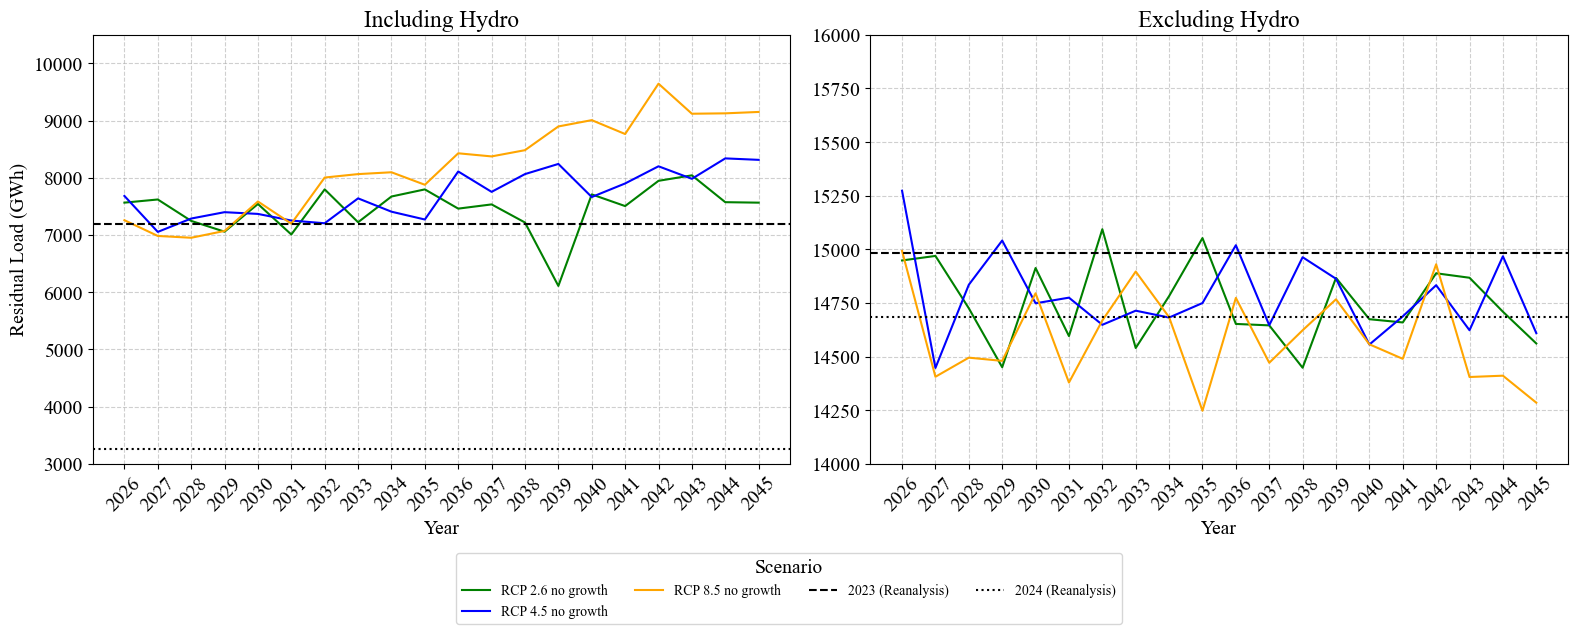

In [124]:
import matplotlib.pyplot as plt

# Ensure 'Year' is int
forecast['Year'] = forecast['Year'].astype(int)
reanalysis['Year'] = reanalysis['Year'].astype(int)

# Exclude 2025
forecast = forecast[forecast['Year'] != 2025]

# Define columns and colors
columns_incl = {
    "Residual Load (GWh) EDP RCP 2.6 no growth": "green",
    "Residual Load (GWh) EDP RCP 4.5 no growth": "blue",
    "Residual Load (GWh) EDP RCP 8.5 no growth": "orange"
}
columns_excl = {
    "Residual Load (GWh) EDP RCP 2.6 ex. Hydro no growth": "green",
    "Residual Load (GWh) EDP RCP 4.5 ex. Hydro no growth": "blue",
    "Residual Load (GWh) EDP RCP 8.5 ex. Hydro no growth": "orange"
}

# Group forecast by year and sum only selected columns
grouped_incl = forecast[['Year'] + list(columns_incl.keys())].groupby('Year').sum()
grouped_excl = forecast[['Year'] + list(columns_excl.keys())].groupby('Year').sum()

# Get the annual sum from reanalysis for 2023 and 2024
baseline_2023_incl = reanalysis[reanalysis['Year'] == 2023]['Residual Load (GWh) EDP'].sum()
baseline_2024_incl = reanalysis[reanalysis['Year'] == 2024]['Residual Load (GWh) EDP'].sum()
baseline_2023_excl = reanalysis[reanalysis['Year'] == 2023]['Residual Load (GWh) EDP ex Hydro'].sum()
baseline_2024_excl = reanalysis[reanalysis['Year'] == 2024]['Residual Load (GWh) EDP ex Hydro'].sum()

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot including hydro
for col, color in columns_incl.items():
    axs[0].plot(grouped_incl.index, grouped_incl[col], label=col.replace("Residual Load (GWh) EDP ", ""), color=color)
axs[0].axhline(y=baseline_2023_incl, color='black', linestyle='--', linewidth=1.5, label='2023 (Reanalysis)')
axs[0].axhline(y=baseline_2024_incl, color='black', linestyle=':', linewidth=1.5, label='2024 (Reanalysis)')
axs[0].set_title("Including Hydro")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Residual Load (GWh)")
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plot excluding hydro
for col, color in columns_excl.items():
    axs[1].plot(grouped_excl.index, grouped_excl[col], label=col.replace("Residual Load (GWh) EDP ", ""), color=color)
axs[1].axhline(y=baseline_2023_excl, color='black', linestyle='--', linewidth=1.5, label='2023 (Reanalysis)')
axs[1].axhline(y=baseline_2024_excl, color='black', linestyle=':', linewidth=1.5, label='2024 (Reanalysis)')
axs[1].set_title("Excluding Hydro")
axs[1].set_xlabel("Year")
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[0].set_ylim(3000, 10500)  # Adjust according to your data
axs[1].set_ylim(14000, 16000)

# Shared formatting
for ax in axs:
    ax.set_xticks(grouped_incl.index)
    ax.set_xticklabels(grouped_incl.index.astype(int), rotation=45)

handles_all, labels_all = axs[0].get_legend_handles_labels()

# Separate scenario lines and historical line
scenario_handles = handles_all[:-1]  # first three = RCPs
scenario_labels = labels_all[:-1]

historic_handle = handles_all[-1]
historic_label = labels_all[-1]

# Create a custom two-row legend using empty labels to break lines
handles_combined = scenario_handles + [historic_handle]
labels_combined = scenario_labels + [historic_label]

# Add shared legend below plots with two rows
fig.legend(handles_combined, labels_combined, loc='center', ncol=4,
           bbox_to_anchor=(0.5, -0.05), fontsize=10, title="Scenario")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

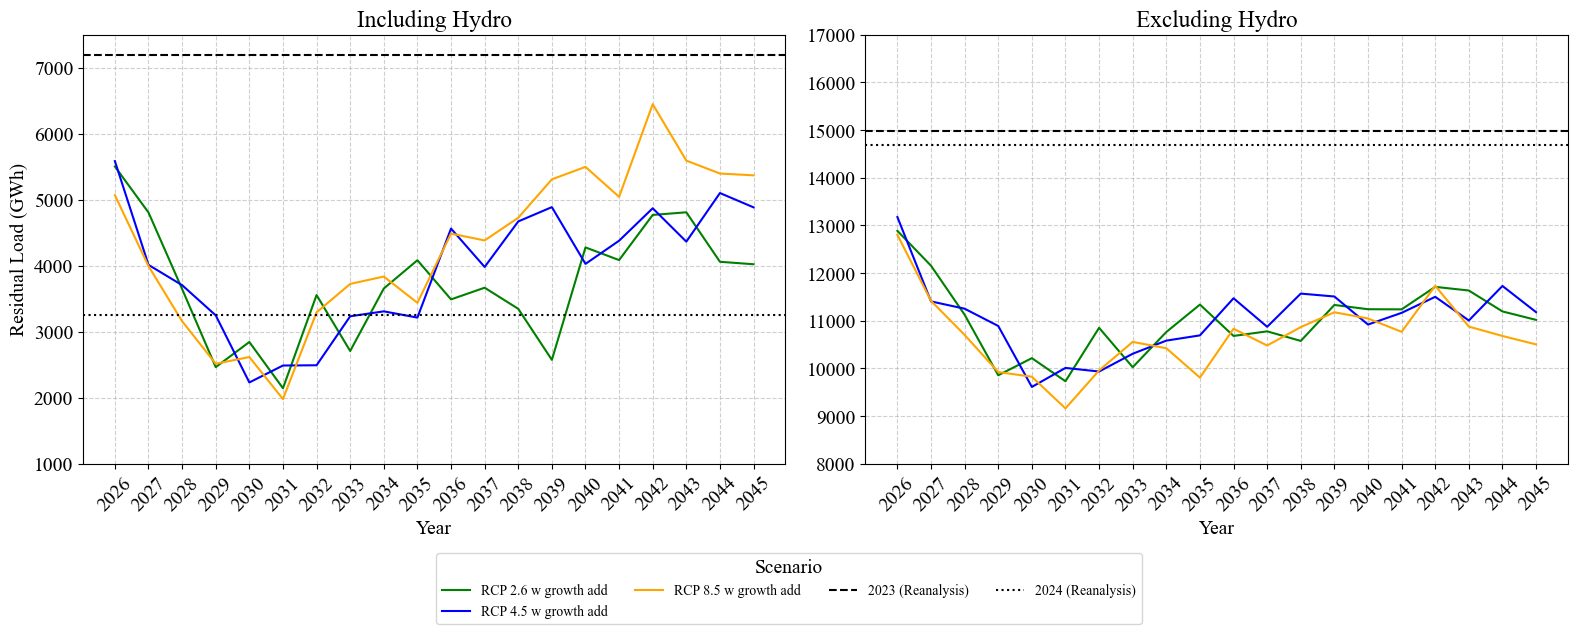

In [125]:
import matplotlib.pyplot as plt

# Ensure 'Year' is int
forecast['Year'] = forecast['Year'].astype(int)
reanalysis['Year'] = reanalysis['Year'].astype(int)

# Exclude 2025
forecast = forecast[forecast['Year'] != 2025]

# Define columns and colors
columns_incl = {
    "Residual Load (GWh) EDP RCP 2.6 w growth add": "green",
    "Residual Load (GWh) EDP RCP 4.5 w growth add": "blue",
    "Residual Load (GWh) EDP RCP 8.5 w growth add": "orange"
}
columns_excl = {
    "Residual Load (GWh) EDP RCP 2.6 ex. Hydro w growth add": "green",
    "Residual Load (GWh) EDP RCP 4.5 ex. Hydro w growth add": "blue",
    "Residual Load (GWh) EDP RCP 8.5 ex. Hydro w growth add": "orange"
}

# Group forecast by year and sum only selected columns
grouped_incl = forecast[['Year'] + list(columns_incl.keys())].groupby('Year').sum()
grouped_excl = forecast[['Year'] + list(columns_excl.keys())].groupby('Year').sum()

# Get the annual sum from reanalysis for 2023 and 2024
baseline_2023_incl = reanalysis[reanalysis['Year'] == 2023]['Residual Load (GWh) EDP'].sum()
baseline_2024_incl = reanalysis[reanalysis['Year'] == 2024]['Residual Load (GWh) EDP'].sum()
baseline_2023_excl = reanalysis[reanalysis['Year'] == 2023]['Residual Load (GWh) EDP ex Hydro'].sum()
baseline_2024_excl = reanalysis[reanalysis['Year'] == 2024]['Residual Load (GWh) EDP ex Hydro'].sum()

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Plot including hydro
for col, color in columns_incl.items():
    axs[0].plot(grouped_incl.index, grouped_incl[col], label=col.replace("Residual Load (GWh) EDP ", ""), color=color)
axs[0].axhline(y=baseline_2023_incl, color='black', linestyle='--', linewidth=1.5, label='2023 (Reanalysis)')
axs[0].axhline(y=baseline_2024_incl, color='black', linestyle=':', linewidth=1.5, label='2024 (Reanalysis)')
axs[0].set_title("Including Hydro")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Residual Load (GWh)")
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plot excluding hydro
for col, color in columns_excl.items():
    axs[1].plot(grouped_excl.index, grouped_excl[col], label=col.replace("Residual Load (GWh) EDP ", ""), color=color)
axs[1].axhline(y=baseline_2023_excl, color='black', linestyle='--', linewidth=1.5, label='2023 (Reanalysis)')
axs[1].axhline(y=baseline_2024_excl, color='black', linestyle=':', linewidth=1.5, label='2024 (Reanalysis)')
axs[1].set_title("Excluding Hydro")
axs[1].set_xlabel("Year")
axs[1].grid(True, linestyle='--', alpha=0.6)

axs[0].set_ylim(1000, 7500)  # Adjust according to your data
axs[1].set_ylim(8000, 17000)

# Shared formatting
for ax in axs:
    ax.set_xticks(grouped_incl.index)
    ax.set_xticklabels(grouped_incl.index.astype(int), rotation=45)

handles_all, labels_all = axs[0].get_legend_handles_labels()

# Separate scenario lines and historical line
scenario_handles = handles_all[:-1]  # first three = RCPs
scenario_labels = labels_all[:-1]

historic_handle = handles_all[-1]
historic_label = labels_all[-1]

# Create a custom two-row legend using empty labels to break lines
handles_combined = scenario_handles + [historic_handle]
labels_combined = scenario_labels + [historic_label]

# Add shared legend below plots with two rows
fig.legend(handles_combined, labels_combined, loc='center', ncol=4,
           bbox_to_anchor=(0.5, -0.05), fontsize=10, title="Scenario")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [126]:
forecast_2026_2045 = forecast[forecast['LocalTime'] >= '2026-01-01 00:00:00']
forecast_2026_2045 = forecast_2026_2045[forecast_2026_2045['LocalTime'] < '2046-01-01 00:00:00']

In [151]:
source_cols = [
    'RCP2_6_Wind', 'RCP4_5_Wind', 'RCP8_5_Wind',
    'RCP2_6_Photovoltaics', 'RCP4_5_Photovoltaics', 'RCP8_5_Photovoltaics',
    'RCP2_6_Hydro', 'RCP4_5_Hydro', 'RCP8_5_Hydro'
]

result_df = compute_vre_variability(forecast_2026_2045, 'LocalTime', source_cols)

## How much additions required in VRE?

In [128]:
# common inputs
capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}
source_cols = [
    'RCP2_6_Wind','RCP4_5_Wind','RCP8_5_Wind',
    'RCP2_6_Photovoltaics','RCP4_5_Photovoltaics','RCP8_5_Photovoltaics',
    'RCP2_6_Hydro','RCP4_5_Hydro','RCP8_5_Hydro'
]
reduction_targets = [0.05, 0.10, 0.25, 0.50]
resid_keyword = "no growth"
storage_gwh = 0.0

# only solar
solar_only = calculate_additional_capacity(
    data=forecast,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics']
)

# only wind
wind_only = calculate_additional_capacity(
    data=forecast,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['wind']
)

# solar + wind (preserves existing cap shares)
solar_wind = calculate_additional_capacity(
    data=forecast,
    source_cols=source_cols,
    capacity_map=capacity_map,
    reduction_targets=reduction_targets,
    storage_gwh=storage_gwh,
    resid_keyword=resid_keyword,
    expand_techs=['photovoltaics','wind']
)

## Coefficients of Variation in different scenarios

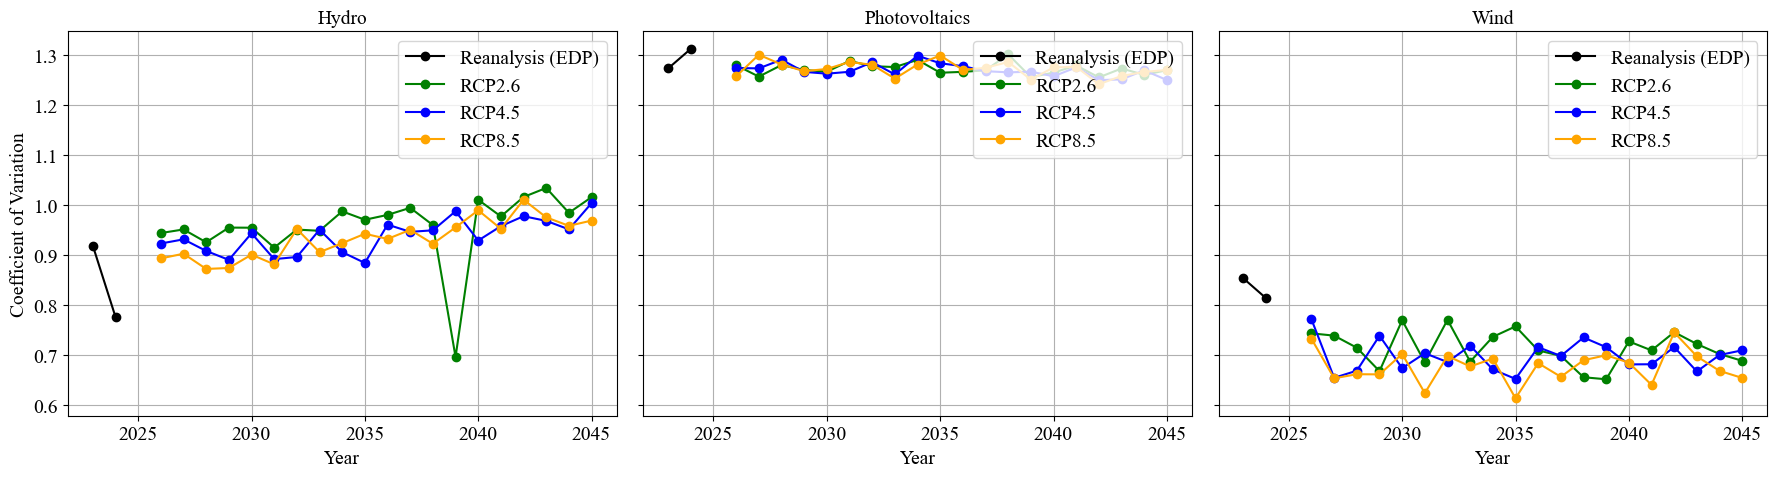

In [221]:
# 1) group & agg → MultiIndex columns: (source, metric)
reanalysis['LocalTime'] = pd.to_datetime(reanalysis['LocalTime'])
# pick only the three columns you need
reanalysis_copy = reanalysis.set_index('LocalTime')[[
    'Hydro EDP', 'Photovoltaics EDP', 'Wind EDP'
]]
baseline_ann = reanalysis_copy.groupby(reanalysis_copy.index.year).agg(['std','mean'])

baseline_ann = baseline_ann[baseline_ann.index < 2025]

# 2) extract std and mean into two plain‐columns DataFrames
baseline_std  = baseline_ann.xs('std',  axis=1, level=1)   # gives columns ['Hydro EDP','Photovoltaics EDP','Wind EDP']
baseline_mean = baseline_ann.xs('mean', axis=1, level=1)

# 3) compute CV and drop the " EDP" suffix
baseline_cv = baseline_std / baseline_mean
baseline_cv.columns = baseline_cv.columns.str.replace(' EDP','') 

# --- 2) compute yearly CV for each RCP scenario ---
# assume forecast_2026_2045 is already a DataFrame with datetime in 'LocalTime'
fc = forecast.copy()
fc['LocalTime'] = pd.to_datetime(fc['LocalTime'])
fc = fc.set_index('LocalTime')

# scenarios dict from your code
scenarios = {
    'RCP2.6': ['RCP2_6_Hydro',        'RCP2_6_Photovoltaics',        'RCP2_6_Wind'],
    'RCP4.5': ['RCP4_5_Hydro',        'RCP4_5_Photovoltaics',        'RCP4_5_Wind'],
    'RCP8.5': ['RCP8_5_Hydro',        'RCP8_5_Photovoltaics',        'RCP8_5_Wind'],
}

colors = {
    'RCP2.6': 'green',
    'RCP4.5': 'blue',
    'RCP8.5': 'orange'
}

cv_scen = {}
for scen, cols in scenarios.items():
    ann = fc[cols].groupby(fc.index.year).agg(['std','mean'])
    std  = ann.xs('std',  axis=1, level=1)
    mean = ann.xs('mean', axis=1, level=1)
    cv   = std / mean
    cv.columns = [c.split('_')[-1] for c in cv.columns]
    cv_scen[scen] = cv

# concatenate into one DataFrame with MultiIndex (scenario, source)
cv_scen_df = pd.concat(cv_scen, axis=1)
# cv_scen_df.loc[year, (scenario, source)] gives the CV

# --- 3) plot side‑by‑side panels ---
sources   = ['Hydro','Photovoltaics','Wind']
years_bas = baseline_cv.index
years_scn = cv_scen_df.index  # e.g. 2025–2045

fig, axes = plt.subplots(1, 3, figsize=(18,5), sharey=True)
for ax, source in zip(axes, sources):
    # baseline in black
    ax.plot(years_bas, baseline_cv[source],
            color='black', linestyle='-', marker='o', label='Reanalysis (EDP)')
    # each scenario
    for scen in scenarios:
        ax.plot(years_scn, cv_scen_df[scen][source],
                marker='o', label=scen, color=colors[scen])
    ax.set_title(source, fontsize=14)
    ax.set_xlabel('Year')
    if source == 'Hydro':
        ax.set_ylabel('Coefficient of Variation')
    ax.legend(loc='upper right')
    ax.grid(True)

plt.tight_layout()
plt.show()

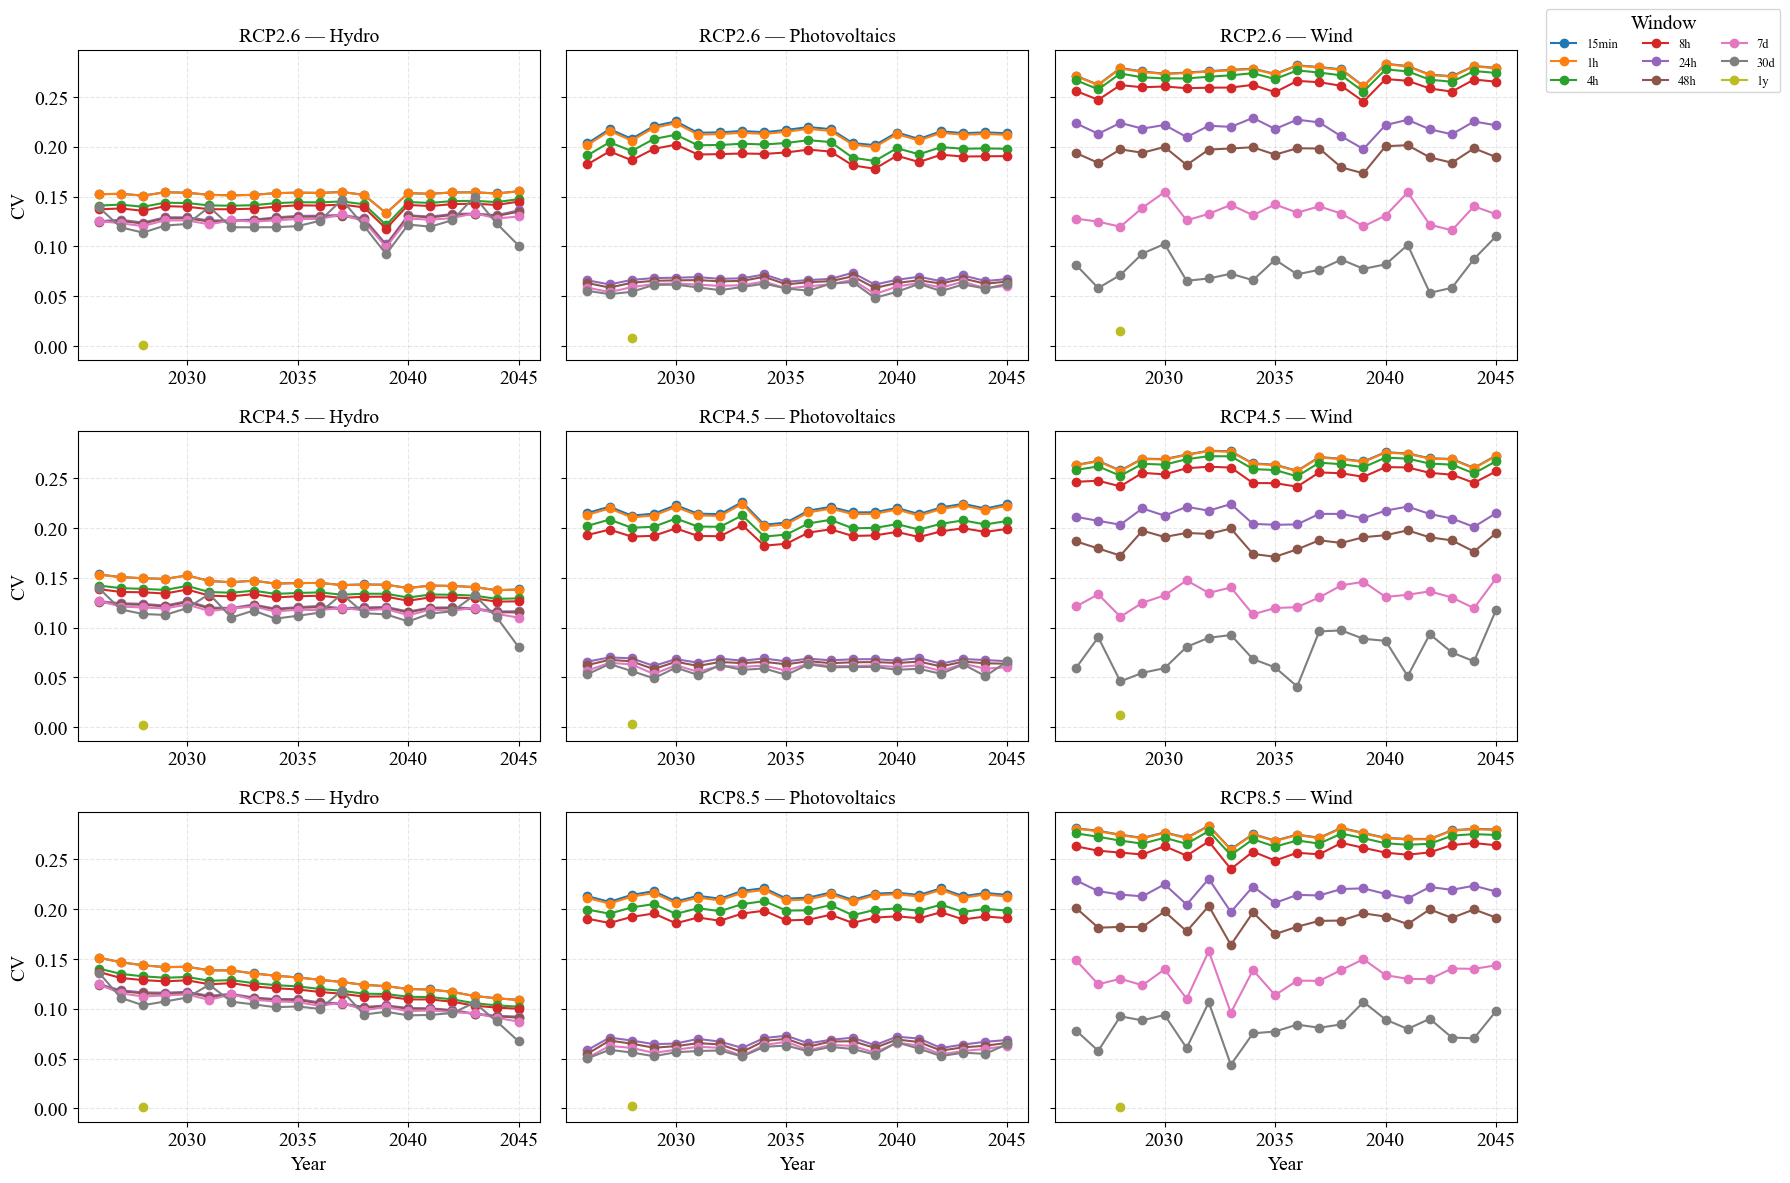

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# — your capacity & window definitions —
capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}
windows = {
    '15min':'15min', '1h':'1h',   '4h':'4h',   '8h':'8h',
    '24h':'1D',     '48h':'2D',   '7d':'7D',   '30d':'30D',
    '1y':'365D'
}

# — load & index your forecast data —
fc = forecast.copy()
fc['LocalTime'] = pd.to_datetime(fc['LocalTime'])
fc = fc.set_index('LocalTime')
# restrict to exactly 2025–2045
fc = fc['2025':'2045']

# — scenarios dict —
scenarios = {
    'RCP2.6': ['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind'],
    'RCP4.5': ['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind'],
    'RCP8.5': ['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind'],
}

years = np.arange(2025, 2046)

# — compute annual CVs per window, per scenario & source —
cv_times = {scen: {} for scen in scenarios}
for scen, cols in scenarios.items():
    for full_col in cols:
        # infer source name and capacity
        src = full_col.split('_')[-1].lower()          
        cap = capacity_map[src]
        
        # prepare a DataFrame to hold CV by year × window
        df_cv = pd.DataFrame(index=years, columns=windows.keys(), dtype=float)
        
        series = fc[full_col]                            
        for wlabel, wf in windows.items():
            # 1) get rolling‐window aggregates (sum) in GWh
            agg = series.resample(wf).sum() / 1_000_000  

            # 2) compute std within each calendar year
            std_by_year = agg.groupby(agg.index.year).std()
            
            # 3) expected max (GWh) per period
            period_h = pd.to_timedelta(wf).total_seconds()/3600
            exp_max = cap * period_h / 1000              
            
            # 4) CV = std / expected_max
            cv = std_by_year / exp_max
            
            # 5) align into our df_cv
            for yr, val in cv.items():
                if 2025 <= yr <= 2045:
                    df_cv.at[yr, wlabel] = val
        
        cv_times[scen][src.capitalize()] = df_cv

# — 3×3 plotting: rows=scenarios, cols=sources —
scenario_names = ['RCP2.6','RCP4.5','RCP8.5']
source_names   = ['Hydro','Photovoltaics','Wind']
colors         = plt.cm.tab10.colors  # for up to 10 distinct lines

fig, axes = plt.subplots(3, 3, figsize=(18,12), sharey=True)
for i, scen in enumerate(scenario_names):
    for j, src in enumerate(source_names):
        ax = axes[i, j]
        dfcv = cv_times[scen][src]  # index=year, cols=window labels
        
        # plot each window as its own line
        for k, wlabel in enumerate(windows.keys()):
            ax.plot(
                years.astype(int), dfcv[wlabel],
                label=wlabel,
                marker='o',
                linestyle='-',
                color=colors[k]
            )

        ax.xaxis.set_major_locator(mticker.MultipleLocator(5)) 
        
        ax.set_title(f"{scen} — {src}", fontsize=14)
        if i == 2:
            ax.set_xlabel('Year')
        if j == 0:
            ax.set_ylabel('CV')
        ax.grid(True, linestyle='--', alpha=0.3)
        if i == 0 and j == 2:
            # only one legend for the top‑right plot
            ax.legend(
                ncol=3, bbox_to_anchor=(1.05,1.15),
                title='Window', fontsize=9
            )

plt.tight_layout()
plt.show()

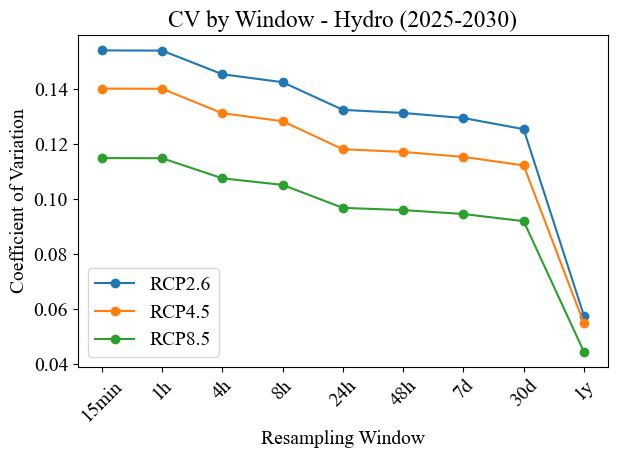

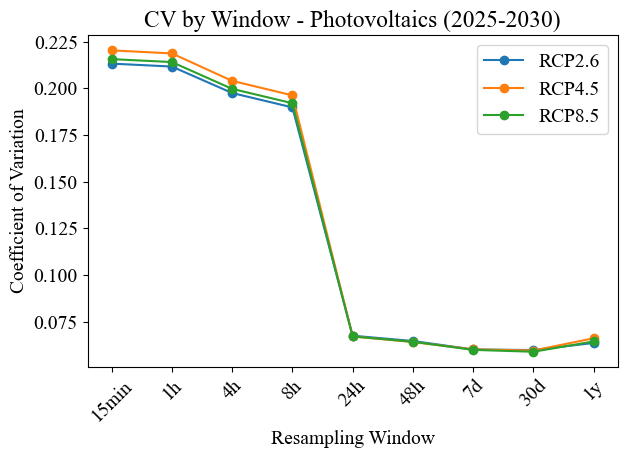

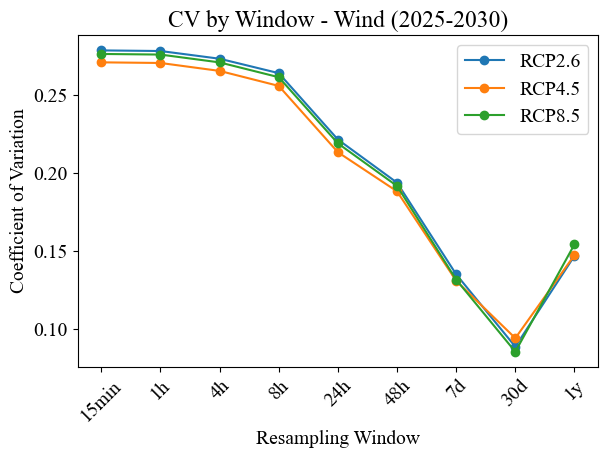

In [131]:
capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}
windows = {
    '15min': '15min', '1h': '1h', '4h': '4h', '8h': '8h',
    '24h': '1D', '48h': '2D', '7d': '7D', '30d': '30D', '1y': '365D'
}

def compute_metrics(df, datetime_col, source_cols, capacity_map, windows):
    df = df.set_index(datetime_col)
    metrics = {}
    for label, freq in windows.items():
        res = df[source_cols].resample(freq).sum() / 1_000_000  # convert to GWh
        stds = res.std()
        period_hours = pd.to_timedelta(freq).total_seconds() / 3600
        cvs = {}
        for src in source_cols:
            cap = next(cap for key, cap in capacity_map.items() if key in src.lower())
            expected_max = cap * period_hours / 1000
            cvs[src] = stds[src] / expected_max if expected_max else np.nan
        metrics[label] = {'std': stds, 'cv': pd.Series(cvs)}
    std_df = pd.DataFrame({lbl: m['std'] for lbl, m in metrics.items()}).T
    cv_df = pd.DataFrame({lbl: m['cv'] for lbl, m in metrics.items()}).T
    std_df.columns = pd.MultiIndex.from_product([std_df.columns, ['std']])
    cv_df.columns = pd.MultiIndex.from_product([cv_df.columns, ['cv']])
    return pd.concat([std_df, cv_df], axis=1).sort_index(axis=1)

# Compute for period 2025-2030 per scenario
scenarios = {
    'RCP2.6': ['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind'],
    'RCP4.5': ['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind'],
    'RCP8.5': ['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind']
}
results = {}
mask = (forecast_2026_2045['LocalTime'] >= '2040-01-01') & (forecast_2026_2045['LocalTime'] < '2045-12-31')
for scenario, cols in scenarios.items():
    results[scenario] = compute_metrics(forecast_2026_2045.loc[mask], 'LocalTime', cols, capacity_map, windows)

# Combine into a single DataFrame
combined_all = pd.concat(results, axis=1)
combined_all.sort_index(axis=1, level=[0,1], inplace=True)

# Plot CV comparison by source
prefix_map = {'RCP2.6':'RCP2_6', 'RCP4.5':'RCP4_5', 'RCP8.5':'RCP8_5'}
for source in ['Hydro', 'Photovoltaics', 'Wind']:
    plt.figure()
    for scenario in scenarios:
        prefix = prefix_map[scenario]
        col = (f"{prefix}_{source}", 'cv')
        plt.plot(combined_all.index, combined_all[scenario][col], marker='o', label=scenario)
    plt.title(f'CV by Window - {source} (2025-2030)')
    plt.xlabel('Resampling Window')
    plt.ylabel('Coefficient of Variation')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

## VRE Variability

### 2.6

In [69]:
vre_variability_2_6_2025 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2025-01-01 00:00:00') & (forecast['LocalTime'] < '2030-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind']
)

vre_variability_2_6_2030 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2030-01-01 00:00:00') & (forecast['LocalTime'] < '2035-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind']
)

vre_variability_2_6_2035 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2035-01-01 00:00:00') & (forecast['LocalTime'] < '2040-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind']
)

vre_variability_2_6_2040 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2040-01-01 00:00:00') & (forecast['LocalTime'] < '2045-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP2_6_Hydro', 'RCP2_6_Photovoltaics', 'RCP2_6_Wind']
)

### 4.5

In [70]:
vre_variability_4_5_2025 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2025-01-01 00:00:00') & (forecast['LocalTime'] < '2030-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind']
)

vre_variability_4_5_2030 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2030-01-01 00:00:00') & (forecast['LocalTime'] < '2035-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind']
)

vre_variability_4_5_2035 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2035-01-01 00:00:00') & (forecast['LocalTime'] < '2040-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind']
)

vre_variability_4_5_2040 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2040-01-01 00:00:00') & (forecast['LocalTime'] < '2045-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP4_5_Hydro', 'RCP4_5_Photovoltaics', 'RCP4_5_Wind']
)

### 8.5

In [71]:
vre_variability_8_5_2025 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2025-01-01 00:00:00') & (forecast['LocalTime'] < '2030-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind']
)

vre_variability_8_5_2030 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2030-01-01 00:00:00') & (forecast['LocalTime'] < '2035-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind']
)

vre_variability_8_5_2035 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2035-01-01 00:00:00') & (forecast['LocalTime'] < '2040-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind']
)

vre_variability_8_5_2040 = compute_vre_variability(
    df=forecast[(forecast['LocalTime'] >= '2040-01-01 00:00:00') & (forecast['LocalTime'] < '2045-01-01 00:00:00')],
    datetime_col='LocalTime',
    source_cols=['RCP8_5_Hydro', 'RCP8_5_Photovoltaics', 'RCP8_5_Wind']
)

### Capacity Factor Plot 

In [132]:
max_possible_output_hydro = 5220 * 8760 / 1000
max_possible_output_wind = 1198 * 8760 / 1000
max_possible_output_solar = 539 * 8760 / 1000

In [133]:
forecast_2026_2045['Year'] = forecast_2026_2045['LocalTime'].dt.year

In [134]:
yearly_sums = forecast_2026_2045[['Year','RCP2_6_Hydro', 'RCP2_6_Wind', 'RCP2_6_Photovoltaics','RCP4_5_Hydro', 'RCP4_5_Wind', 'RCP4_5_Photovoltaics','RCP8_5_Hydro', 'RCP8_5_Wind', 'RCP8_5_Photovoltaics']].groupby('Year').sum()

In [135]:
season_map = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}

forecast_2026_2045['Month'] = forecast_2026_2045['LocalTime'].dt.month
forecast_2026_2045['Season'] = forecast_2026_2045['Month'].map(season_map)

seasonal_sums = (
    forecast_2026_2045
    .groupby(['Year', 'Season'])[
        ['RCP2_6_Hydro', 'RCP2_6_Wind', 'RCP2_6_Photovoltaics',
         'RCP4_5_Hydro', 'RCP4_5_Wind', 'RCP4_5_Photovoltaics',
         'RCP8_5_Hydro', 'RCP8_5_Wind', 'RCP8_5_Photovoltaics']
    ]
    .sum()
    .reset_index()         # ← this makes Year and Season columns again
)


Add 2020-2025 (ERA5) to see the difference

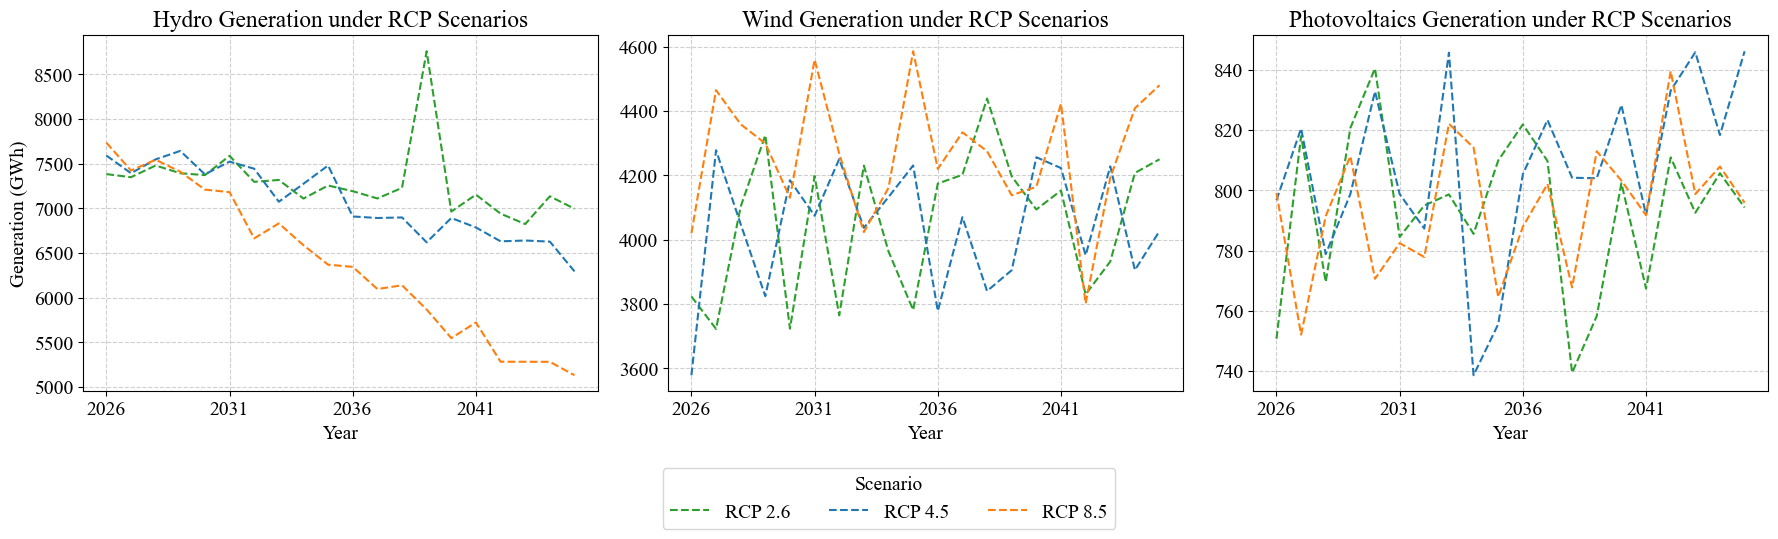

In [136]:
year_col = 'Year'
yearly_sums[year_col] = yearly_sums.index

# Get prefixes
prefixes = sorted({ '_'.join(col.split('_')[:2]) for col in yearly_sums.columns if col != year_col })

# Pretty names
prefix_to_display = {p: p.replace('RCP', 'RCP ').replace('_', '.') for p in prefixes}

# Style map
style = {
    'RCP 2.6': {'color': 'tab:green', 'linestyle': '--'},
    'RCP 4.5': {'color': 'tab:blue', 'linestyle': '--'},
    'RCP 8.5': {'color': 'tab:orange', 'linestyle': '--'},
}

sources = ['Hydro', 'Wind', 'Photovoltaics']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

for i, source in enumerate(sources):
    ax = axs[i]
    for prefix, display in prefix_to_display.items():
        col_name = f'{prefix}_{source}'
        if col_name not in yearly_sums.columns:
            continue
        props = style.get(display, {})
        line = ax.plot(
            yearly_sums[year_col].astype(int),
            yearly_sums[col_name] / 1000000,  # Convert to GWh
            label=display,
            color=props.get('color'),
            linestyle=props.get('linestyle')
        )
    ax.set_title(f'{source} Generation under RCP Scenarios')
    ax.set_xlabel('Year')
    if i == 0:
        ax.set_ylabel(f'Generation (GWh)')
    
    # Set x-ticks every 5 years
    min_year = yearly_sums[year_col].min()
    max_year = yearly_sums[year_col].max()
    ax.set_xticks(np.arange(min_year, max_year + 1, 5))
    ax.grid(True, linestyle='--', alpha=0.6)

# Collect legend items from the first axis
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), title='Scenario')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

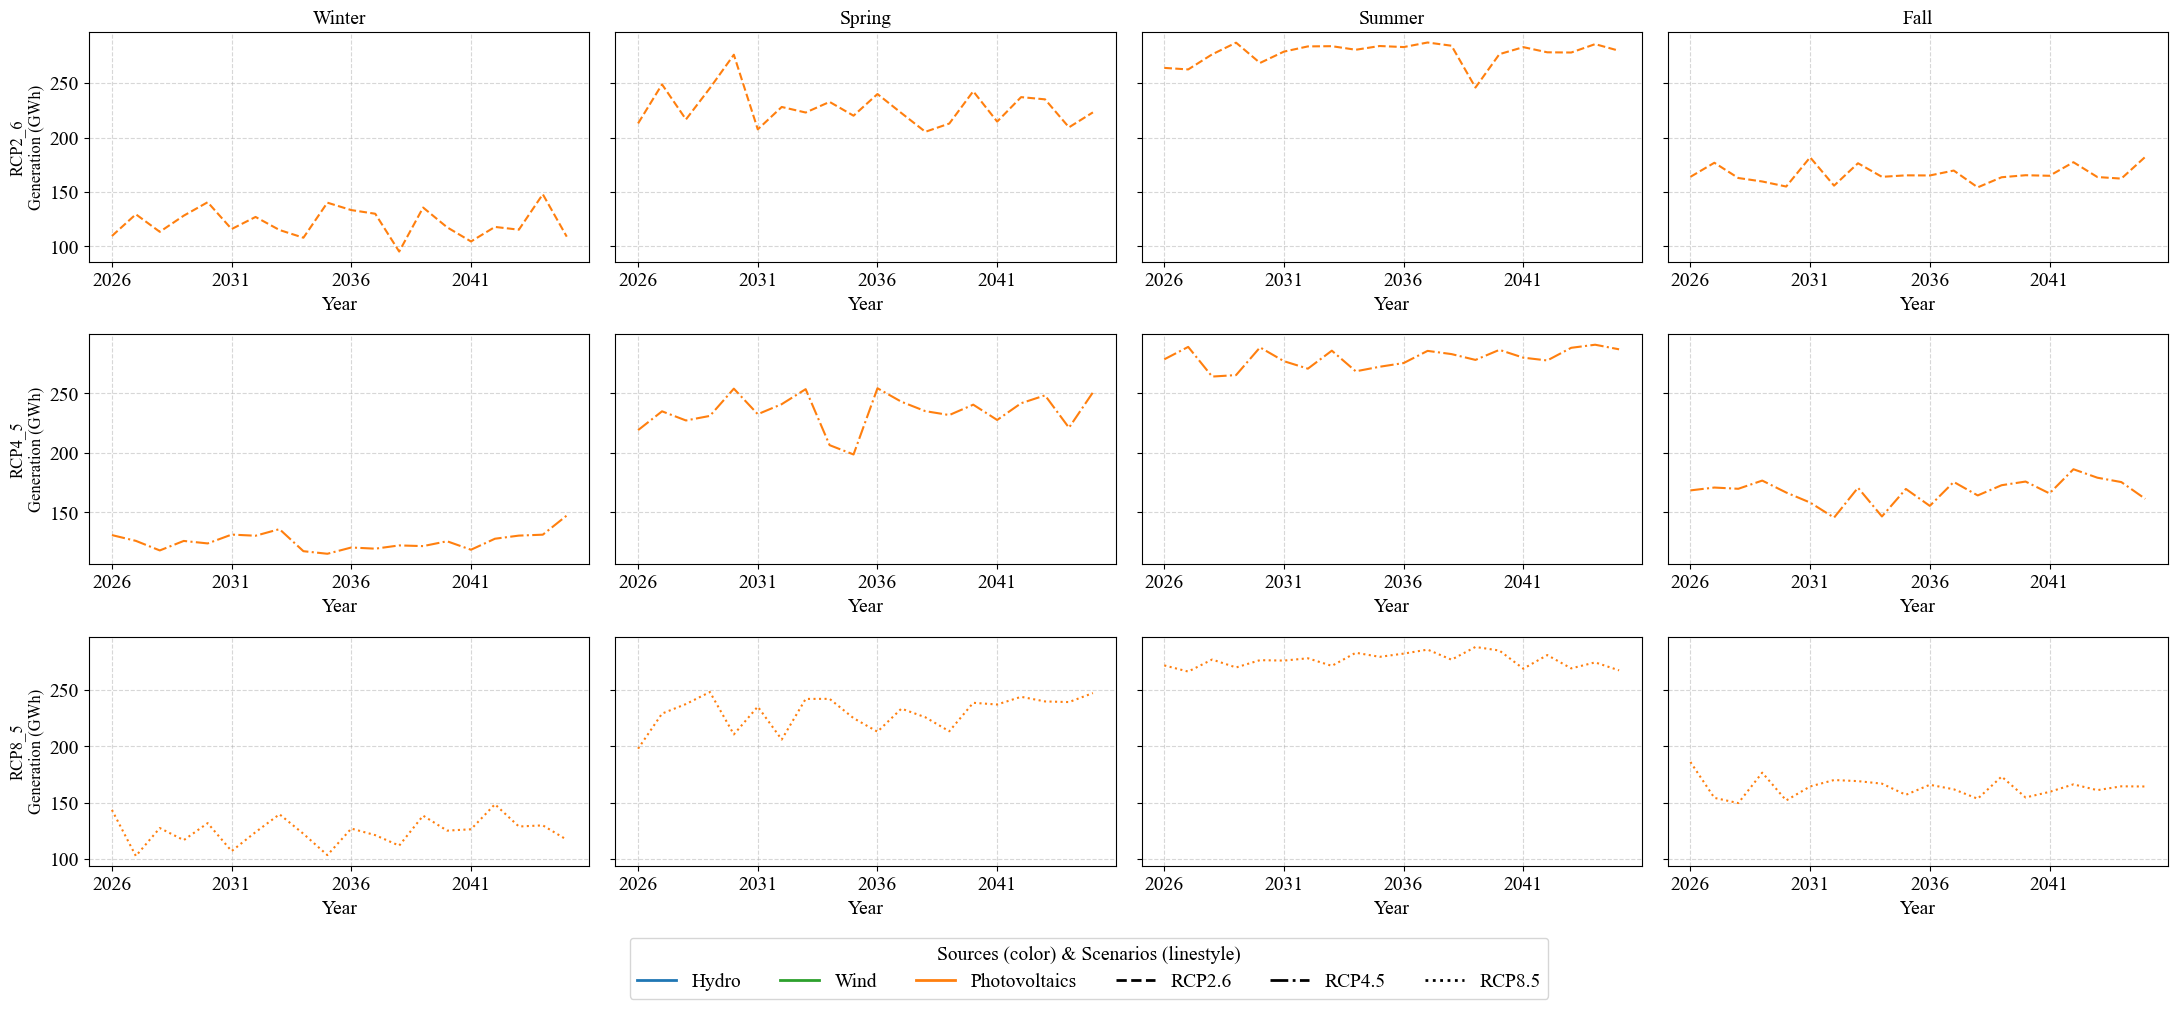

In [98]:
seasons   = ['Winter', 'Spring', 'Summer', 'Fall']
scenarios = ['RCP2_6', 'RCP4_5', 'RCP8_5']
sources   = ['Photovoltaics']

# Map each source to a distinct color
source_color = {
    'Hydro':         'tab:blue',
    'Wind':          'tab:green',
    'Photovoltaics': 'tab:orange'
}

# Map each scenario to a distinct linestyle
scenario_ls = {
    'RCP2_6': '--',
    'RCP4_5': '-.',
    'RCP8_5': ':'
}

fig, axs = plt.subplots(len(scenarios), len(seasons),
                        figsize=(22, 10), sharey='row',
                        squeeze=False)

for i, scenario in enumerate(scenarios):
    for j, season in enumerate(seasons):
        ax = axs[i, j]
        df_seas = seasonal_sums[seasonal_sums['Season'] == season]
        
        for source in sources:
            col = f"{scenario}_{source}"
            if col not in df_seas:
                continue
            
            ax.plot(
                df_seas['Year'].astype(int),
                df_seas[col] / 1e6,            # convert to GWh
                label=source if (i, j) == (0, 0) else "",  
                color=source_color[source],
                linestyle=scenario_ls[scenario],
                linewidth=1.5
            )
        
        if i == 0:
            ax.set_title(season, fontsize=14)
        if j == 0:
            ax.set_ylabel(f"{scenario}\nGeneration (GWh)", fontsize=12)
        ax.set_xlabel('Year')
        ax.set_xticks(np.arange(df_seas['Year'].min(),
                                df_seas['Year'].max()+1, 5))
        ax.grid(True, linestyle='--', alpha=0.5)

# Create a combined legend: one entry per source, plus one per scenario linestyle
# First handles for sources:
source_handles = [
    plt.Line2D([], [], color=clr, linestyle='-', lw=2, label=src)
    for src, clr in source_color.items()
]
# Then handles for scenarios:
scenario_handles = [
    plt.Line2D([], [], color='k', linestyle=ls, lw=2, label=sc.replace('_', '.'))
    for sc, ls in scenario_ls.items()
]

fig.legend(
    handles=source_handles + scenario_handles,
    loc='lower center',
    ncol= len(source_handles + scenario_handles),
    bbox_to_anchor=(0.5, -0.02),
    title='Sources (color) & Scenarios (linestyle)'
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

In [18]:
yearly_sums.index

Index([2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037,
       2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045],
      dtype='int32', name='Year')

In [76]:
forecast[['Year', 'RCP8_5_Photovoltaics_add']].groupby('Year').sum()

,RCP8_5_Photovoltaics_add
Year,
2026,2.281808e+09
2027,2.147377e+09
2028,2.259709e+09
2029,2.316596e+09
2030,2.200329e+09
2031,2.234115e+09
2032,2.220950e+09
2033,2.347236e+09
2034,2.324702e+09


In [86]:
forecast[['Year', 'RCP8_5_Hydro']].groupby('Year').sum()

,RCP8_5_Hydro
Year,
2026,7.793012e+09
2027,7.520006e+09
2028,7.697871e+09
2029,7.625881e+09
2030,7.477922e+09
2031,7.494877e+09
2032,7.067261e+09
2033,7.239793e+09
2034,7.052991e+09


In [137]:
forecast_2042 = forecast[forecast['Year'] == 2042]

In [138]:
forecast_2042.groupby(forecast_2042['LocalTime'].dt.date)['Residual Load (GWh) EDP RCP 8.5 w growth add'].sum().mean()

17.669354409777558

In [82]:
reanalysis.groupby(reanalysis['LocalTime'].dt.date)['Residual Load (GWh) EDP'].sum().mean()

12.824212893353073

In [ ]:
forecast_2042[['LocalTime', 'Residual Load (GWh) EDP RCP 8.5 w growth add']].groupby('LocalTime').sum()

## Optimizing Portfolio Additions for each climate scenario

In [182]:
cost_schedule_usd = {
    2025: {
        "photovoltaics": 750,   # USD per kW
        "wind"       : 2375,    # USD per kW (mean of onshore and offshore)
        "battery"    : 250,     # USD per kWh
    },
    2030: {
        "photovoltaics": 480,
        "wind"       :  1915,
        "battery"    : 175,
    },
    2050: {
        "photovoltaics": 340,
        "wind"       :  1575,
        "battery"    : 155,
    },
}

capacity_map = {'hydro': 5220, 'photovoltaics': 539, 'wind': 1198}

In [206]:
additions, results = optimize_investment_mix(data=forecast,
                                             capacity_map=capacity_map,
                                             cost_schedule_usd=cost_schedule_usd,
                                             start_year=2026,
                                             end_year=2045,
                                             annual_investment_eur=500_000_000,
                                             growth_rate=0,
                                             delta_mw=1,
                                             max_steps=1600
                                             )

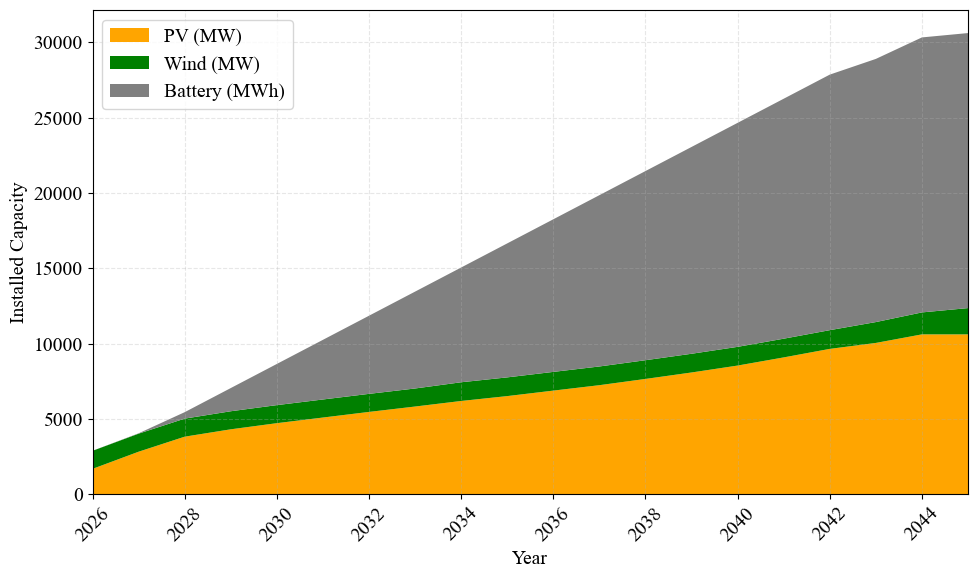

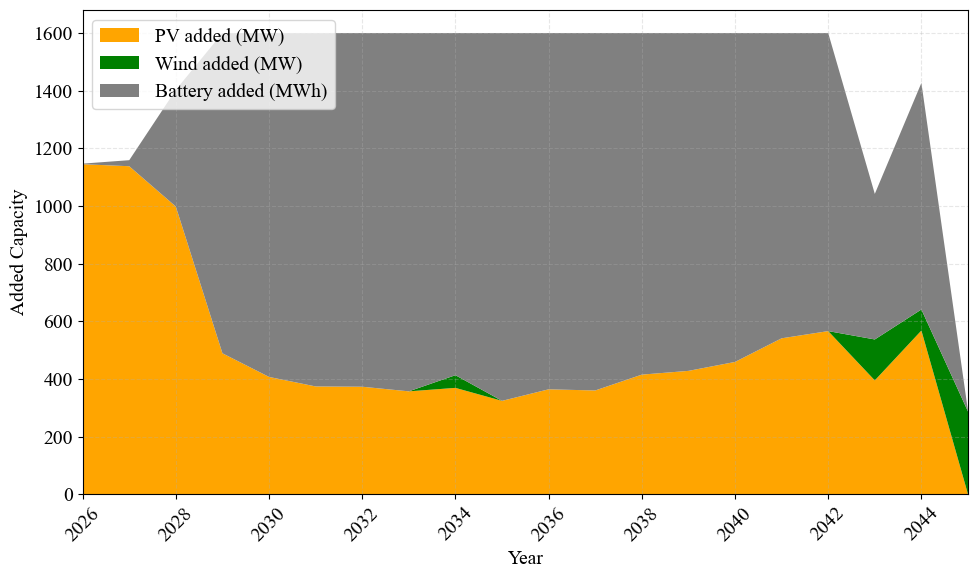

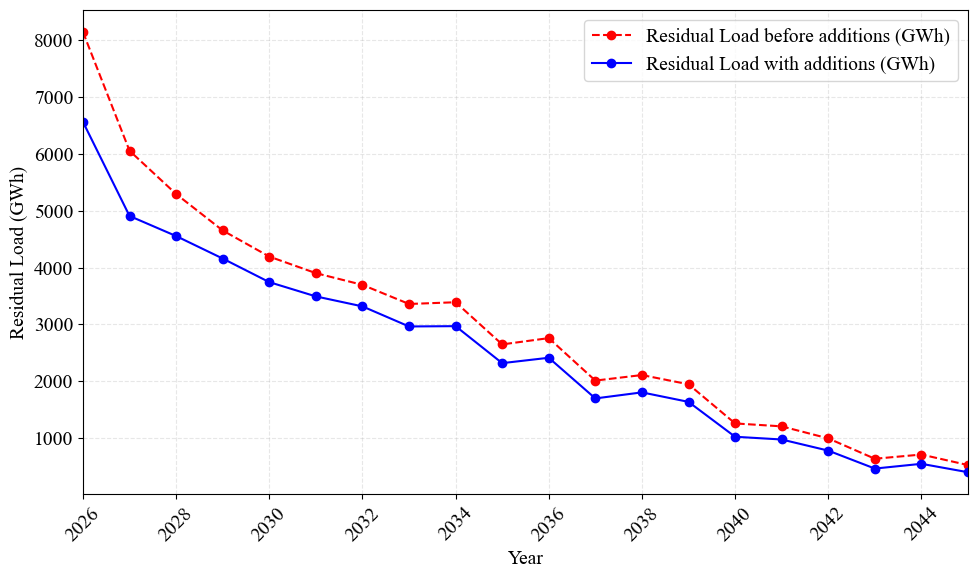

In [213]:
def plot_portfolio_evolution(results: pd.DataFrame, scenario: str = "RCP4_5_w_growth"):
    """
    Plots cumulative and added capacities for PV, wind, and battery (in MW and MWh).
    Also plots the reduction in energy deficit over time.
    """
    # Extract the scenario-specific data
    df = results.xs(scenario, level="scenario")

    # Extract years
    years = df.index.values.astype(int)

    # Cumulative values
    pv_cum    = df["pv_cum"].values
    wind_cum  = df["wind_cum"].values
    batt_cum  = df["batt_cum"].values * 1000  # Convert GWh to MWh

    # Added values
    pv_add    = df["pv_added"].values
    wind_add  = df["wind_added"].values
    batt_add  = df["batt_added"].values * 1000  # Convert GWh to MWh

    # Deficits
    initial_deficit = df["initial_deficit_GWh"].values
    final_deficit   = df["deficit_GWh"].values

    # Set up common x-axis ticks (2-year interval)
    x_ticks = np.arange(years.min(), years.max() + 1, 2)

    # --- Plot 1: Cumulative Capacity ---
    plt.figure(figsize=(10, 6))
    plt.stackplot(years, pv_cum, wind_cum, batt_cum,
                  labels=["PV (MW)", "Wind (MW)", "Battery (MWh)"],
                  colors=["orange", "green", "grey"])
    plt.xlim(years.min(), years.max())
    plt.xticks(x_ticks, rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Installed Capacity")
    #plt.title(f"Cumulative Portfolio Evolution: {scenario}")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Yearly Additions ---
    plt.figure(figsize=(10, 6))
    plt.stackplot(years, pv_add, wind_add, batt_add,
                  labels=["PV added (MW)", "Wind added (MW)", "Battery added (MWh)"],
                  colors=["orange", "green", "grey"])
    plt.xlim(years.min(), years.max())
    plt.xticks(x_ticks, rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Added Capacity")
    #plt.title(f"Annual Capacity Additions: {scenario}")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Plot 3: Deficit Reduction ---
    plt.figure(figsize=(10, 6))
    plt.plot(years, initial_deficit, label="Residual Load before additions (GWh)", linestyle="--", marker="o", color="red")
    plt.plot(years, final_deficit, label="Residual Load with additions (GWh)", linestyle="-", marker="o", color="blue")
    plt.xlim(years.min(), years.max())
    plt.xticks(x_ticks, rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Residual Load (GWh)")
    #plt.title(f"Deficit Reduction Over Time: {scenario}")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# Call it:
plot_portfolio_evolution(results, "RCP4_5_w_growth")

In [216]:
def plot_portfolio_evolution_2x2(results: pd.DataFrame, scenario: str = "RCP4_5_w_growth"):
    """
    Creates a 2×2 grid of plots for a given scenario, with:
      - Top-left: cumulative capacities for PV, wind, and battery.
      - Top-right: annual added capacities for PV, wind, and battery.
      - Bottom (spanning both columns): residual load reduction (initial vs. with additions).
    
    Parameters:
    -----------
    results : pd.DataFrame
        MultiIndex DataFrame with 'scenario' as one level, and year as the index.
        Must contain columns:
          - "pv_cum", "wind_cum", "batt_cum"       : cumulative capacities (MW or GWh)
          - "pv_added", "wind_added", "batt_added" : annual added capacities (MW or GWh)
          - "initial_deficit_GWh", "deficit_GWh"   : residual load values in GWh
    scenario : str
        The scenario key to select from the 'scenario' level of the MultiIndex.
    """
    # Extract the scenario-specific slice
    df = results.xs(scenario, level="scenario")

    # Years (as integers)
    years = df.index.values.astype(int)

    # Cumulative capacities (convert batt from GWh to MWh)
    pv_cum   = df["pv_cum"].values
    wind_cum = df["wind_cum"].values
    batt_cum = df["batt_cum"].values * 1000

    # Annual additions (convert batt from GWh to MWh)
    pv_add   = df["pv_added"].values
    wind_add = df["wind_added"].values
    batt_add = df["batt_added"].values * 1000

    # Residual load values
    initial_deficit = df["initial_deficit_GWh"].values
    final_deficit   = df["deficit_GWh"].values

    # X-axis ticks every 2 years
    x_ticks = np.arange(years.min(), years.max() + 1, 2)

    # Create figure and GridSpec
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.8], hspace=0.3, wspace=0.3)

    # Top-left: Cumulative capacities
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.stackplot(
        years,
        pv_cum, wind_cum, batt_cum,
        labels=["PV cum (MW)", "Wind cum (MW)", "Batt cum (MWh)"],
        colors=["orange", "green", "grey"]
    )
    ax1.set_xlim(years.min(), years.max())
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(x_ticks, rotation=45)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Installed Capacity")
    ax1.legend(loc="upper left")
    ax1.grid(True, linestyle="--", alpha=0.3)

    # Top-right: Annual additions
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.stackplot(
        years,
        pv_add, wind_add, batt_add,
        labels=["PV add (MW)", "Wind add (MW)", "Batt add (MWh)"],
        colors=["orange", "green", "grey"]
    )
    ax2.set_xlim(years.min(), years.max())
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_ticks, rotation=45)
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Added Capacity")
    ax2.legend(loc="upper left")
    ax2.grid(True, linestyle="--", alpha=0.3)

    # Bottom (both columns): Deficit reduction
    ax3 = fig.add_subplot(gs[1, :])
    ax3.plot(
        years, initial_deficit,
        label="Residual load before additions (GWh)",
        linestyle="--", marker="o", color="red"
    )
    ax3.plot(
        years, final_deficit,
        label="Residual load with additions (GWh)",
        linestyle="-", marker="o", color="blue"
    )
    ax3.set_xlim(years.min(), years.max())
    ax3.set_xticks(x_ticks)
    ax3.set_xticklabels(x_ticks, rotation=45)
    ax3.set_xlabel("Year")
    ax3.set_ylabel("Residual Load (GWh)")
    ax3.legend(loc="upper right")
    ax3.grid(True, linestyle="--", alpha=0.3)

    plt.tight_layout()
    plt.show()

/var/folders/dg/bb0t3rbx0wl1m8sfz_m5h2bw0000gn/T/ipykernel_7615/1046562632.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


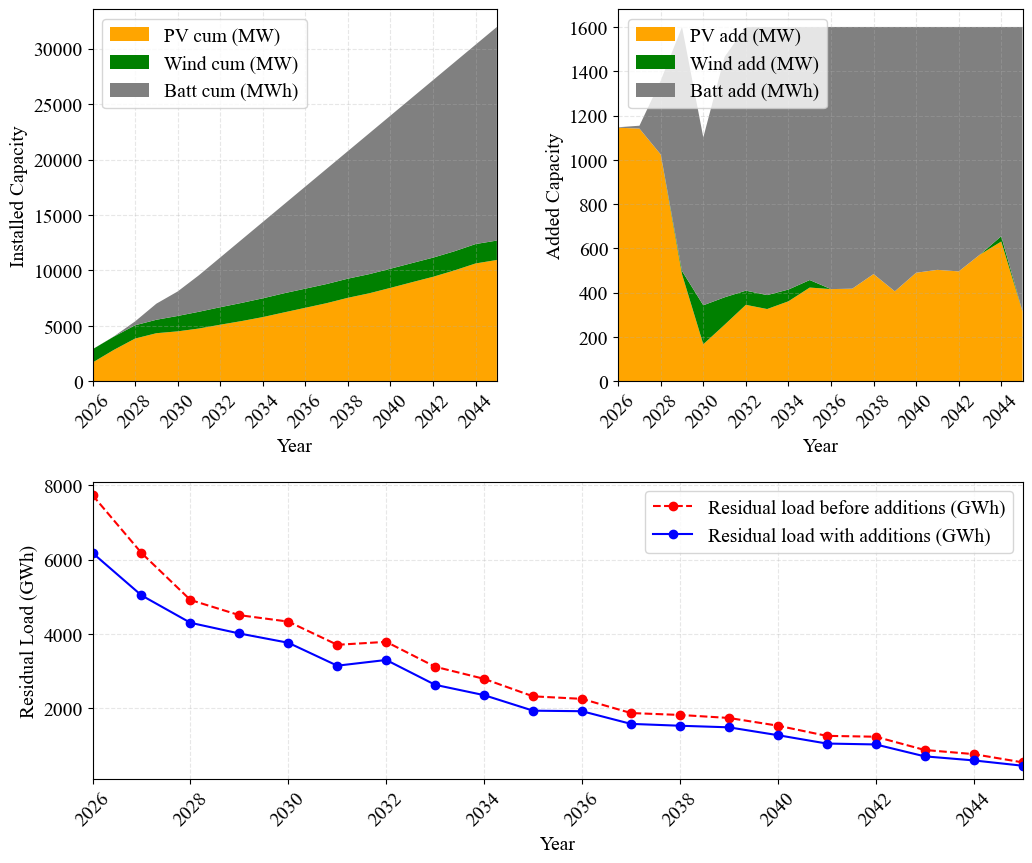

In [227]:
plot_portfolio_evolution_2x2(results, "RCP8_5_w_growth")

In [ ]:
savings_greedy, additions_greedy = optimize_investment_mix_multi_year_rolling_indiv(
    data=forecast,
    capacity_map=capacity_map,
    cost_schedule_usd=cost_schedule_usd,
    start_year=2026,
    end_year=2045,
    annual_investment_eur=1_000_000_000,
    method="greedy"
)

In [13]:
savings_abs, savings_pct, additions = optimize_investment_mix_multi_year(
    data=forecast,
    capacity_map=capacity_map,
    cost_schedule_usd=cost_schedule_usd,
    start_year=2026,
    end_year=2045,
    annual_budget_usd=1e9,
    growth_rate=0.0
)

In [191]:
savings_table, additions = optimize_investment_mix_multi_year(
                                                            data=forecast,
                                                            capacity_map=capacity_map,
                                                            cost_schedule_usd_per_kw=cost_schedule_usd,
                                                            start_year=2026,
                                                            end_year=2028,
                                                            annual_budget_eur=1_000_000_000
                                                                        )

KeyError: 'median_load_kwh'

## Production Output Changes on Plant Level

In [2]:
def process_plant_level_data(df, suffix):
    df_grouped = (
        df[['Year', 'Plant Name', 'power_kWh']]
        .groupby(['Plant Name', 'Year'], as_index=False)
        .sum()
        .sort_values(['Plant Name', 'Year'])
    )
    df_grouped = df_grouped.rename(columns={'power_kWh': f'power_kWh_{suffix}'})
    df_grouped[f'rolling_mean_{suffix}'] = (
        df_grouped
        .groupby('Plant Name')[f'power_kWh_{suffix}']
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )
    return df_grouped

In [3]:
#pv_2_6 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Photovoltaic_rcp_2_6_w_predictions_15min.parquet')
#pv_4_5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Photovoltaic_rcp_4_5_w_predictions_15min.parquet')
#pv_8_5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Photovoltaic_rcp_8_5_w_predictions_15min.parquet')

wind_2_6 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Wind_rcp_2_6_w_predictions_15min.parquet')
wind_2_6['Year'] = wind_2_6['LocalTime'].dt.year
yearly_wind_2_6 = process_plant_level_data(wind_2_6, '2_6')
del wind_2_6
wind_4_5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Wind_rcp_4_5_w_predictions_15min.parquet')
wind_4_5['Year'] = wind_4_5['LocalTime'].dt.year
yearly_wind_4_5 = process_plant_level_data(wind_4_5, '4_5')
del wind_4_5
wind_8_5 = pd.read_parquet('/Users/darcor/Data/EDP Thesis/Output/Predictions/Wind_rcp_8_5_w_predictions_15min.parquet')
wind_8_5['Year'] = wind_8_5['LocalTime'].dt.year
yearly_wind_8_5 = process_plant_level_data(wind_8_5, '8_5')
del wind_8_5

from functools import reduce
dfs = [yearly_wind_2_6, yearly_wind_4_5, yearly_wind_8_5]
final_df = reduce(lambda left, right: pd.merge(left, right, on=['Plant Name', 'Year'], how='outer'), dfs)

final_df = final_df.sort_values(['Plant Name', 'Year'])

wind_plant_overview = final_df[final_df['Year'].isin([2026, 2045])]

In [4]:
wind_plant_overview = final_df[final_df['Year'].isin([2030, 2045])]

In [ ]:
pv_2_6['Year'] = pv_2_6['LocalTime'].dt.year
pv_4_5['Year'] = pv_4_5['LocalTime'].dt.year
pv_8_5['Year'] = pv_8_5['LocalTime'].dt.year


wind_4_5['Year'] = wind_4_5['LocalTime'].dt.year
wind_8_5['Year'] = wind_8_5['LocalTime'].dt.year

### Yearly Level

In [ ]:
def process_plant_level_data(df, suffix):
    df_grouped = (
        df[['Year', 'Plant Name', 'power_kWh']]
        .groupby(['Plant Name', 'Year'], as_index=False)
        .sum()
        .sort_values(['Plant Name', 'Year'])
    )
    df_grouped = df_grouped.rename(columns={'power_kWh': f'power_kWh_{suffix}'})
    df_grouped[f'rolling_mean_{suffix}'] = (
        df_grouped
        .groupby('Plant Name')[f'power_kWh_{suffix}']
        .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    )
    return df_grouped

yearly_pv_2_6 = process_plant_level_data(pv_2_6, '2_6')
yearly_pv_4_5 = process_plant_level_data(pv_4_5, '4_5')
yearly_pv_8_5 = process_plant_level_data(pv_8_5, '8_5')

from functools import reduce
dfs = [yearly_pv_2_6, yearly_pv_4_5, yearly_pv_8_5]
final_df = reduce(lambda left, right: pd.merge(left, right, on=['Plant Name', 'Year'], how='outer'), dfs)

final_df = final_df.sort_values(['Plant Name', 'Year'])

In [15]:
pv_plant_overview = final_df[final_df['Year'].isin([2026, 2045])]